# **1. Introduction to Time Series**

- **Time Series**: A sequence of data points indexed in time order (e.g., daily stock prices, monthly sales).  
- **Components**:  
  - **Trend**: Long-term increase/decrease (e.g., rising GDP).  
  - **Seasonality**: Repeating patterns (e.g., holiday sales spikes).  
  - **Noise**: Random fluctuations.

Ensure these libraries are installed:  
```bash
pip install pandas numpy matplotlib statsmodels
``` 

## **Example: Load & Plot Time Series**

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a simple time series (dates + values)
dates = pd.date_range(start="2020-01-01", periods=365, freq="D")
values = [i + (i % 30) * 2 + np.random.normal(0, 5) for i in range(365)]  # Synthetic data with trend + seasonality

df = pd.DataFrame({"date": dates, "value": values})
df.set_index("date", inplace=True)

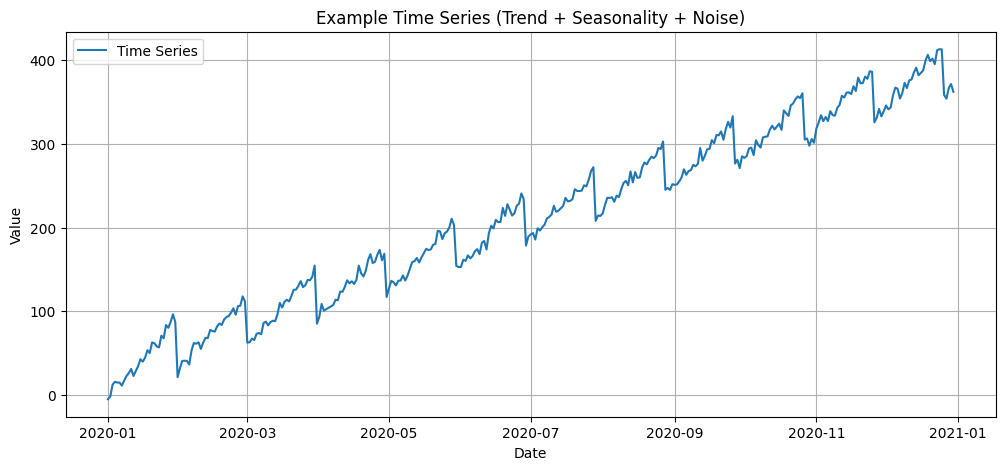

In [72]:
# Plot
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["value"], label="Time Series")
plt.title("Example Time Series (Trend + Seasonality + Noise)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

This plot shows:
- An upward **trend** (values generally increase).  
- **Seasonality** (regular peaks every ~30 days).  
- **Noise** (small random fluctuations).

It is important because:

- Real-world data often mixes these components.  
- Models like ARIMA/SARIMA aim to separate and model them.  

# **2. Loading & Visualizing Time Series**

## **Step 1: Loading Time Series Data**  
**Example Dataset**: Airline Passengers (1949–1960) ([Download CSV](https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv))

In [73]:
import pandas as pd

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df.rename(columns={'Passengers': 'value'}, inplace=True)

print(df.head())

            value
Month            
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121


**Key Checks**:

In [74]:
print(df.index.dtype)  # Must be `datetime64[ns]`
print(df.isnull().sum())  # Check for missing values

datetime64[ns]
value    0
dtype: int64


## **Step 2: Visualizing Time Series**

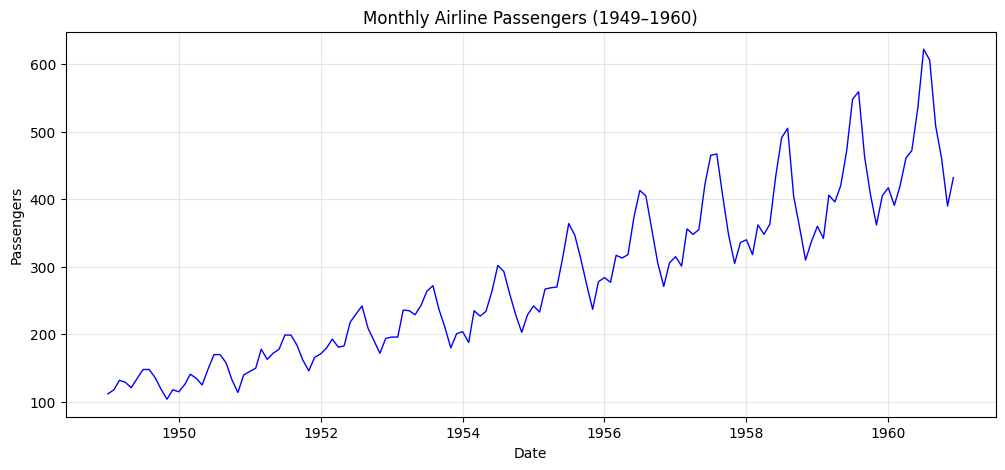

In [75]:
# basic plot

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['value'], color='blue', linewidth=1)
plt.title('Monthly Airline Passengers (1949–1960)')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(alpha=0.3)
plt.show()

**Observation**: Clear upward trend + annual seasonality. 

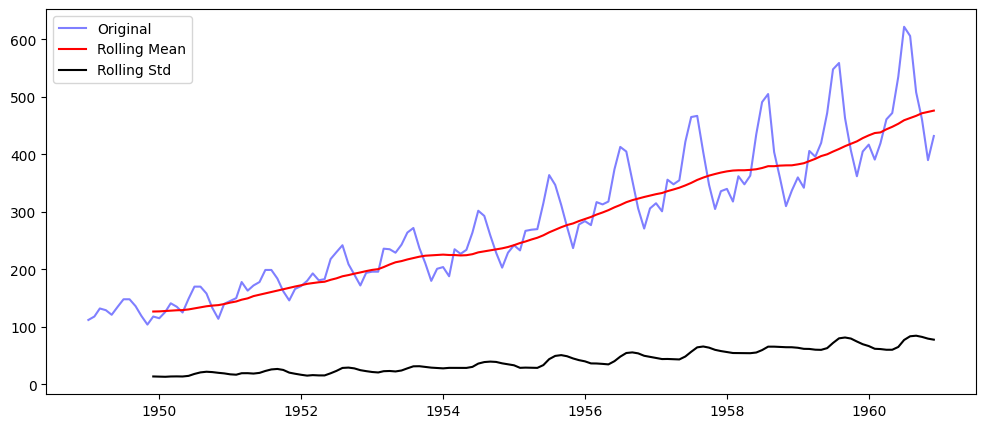

In [76]:
# Rolling Statistics (Trend Detection)

rolling_mean = df['value'].rolling(window=12).mean()  # 12-month rolling mean
rolling_std = df['value'].rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(df['value'], label='Original', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='black')
plt.legend()
plt.show()

**Interpretation**:  
1. Rolling mean confirms **trend**.  

   - If the rolling mean increases or decreases over time, your data has a trend component (non-stationary in mean).

2. Rolling std shows **volatility changes** (non-stationarity). 

   - If the rolling std varies significantly, your data has heteroskedasticity (non-constant variance, a form of non-stationarity).

   - *Heteroscedasticity is a concept used in applied statistics (most often in econometrics), meaning heterogeneity of observations, which is expressed in unequal (non-constant) variance of the random error of the regression (econometric) model.*

3. Before modeling (e.g., with ARIMA), you may need to:

   - Detrend.
   - Stabilize variance.

**Why Detrend and Stabilize Variance?**

1. Detrending Removes Non-Stationarity in Mean

   - Many time series models (e.g., ARIMA) assume the mean is constant over time.

   - A trend (upward/downward drift) violates this assumption → misleading forecasts.

   - Example: If sales are increasing yearly, failing to detrend may lead to overestimating future values.

2. Stabilizing Variance Removes Non-Stationarity in Volatility

   - Models assume constant variance (homoskedasticity).

   - If volatility changes (heteroskedasticity), confidence intervals and predictions become unreliable.

   - Example: Stock returns may have low volatility in calm markets but extreme swings during crises.

## **Step 3: Time Series Decomposition**

Decompose into **trend**, **seasonality**, and **residuals** (irregular components or noise) using `statsmodels`:

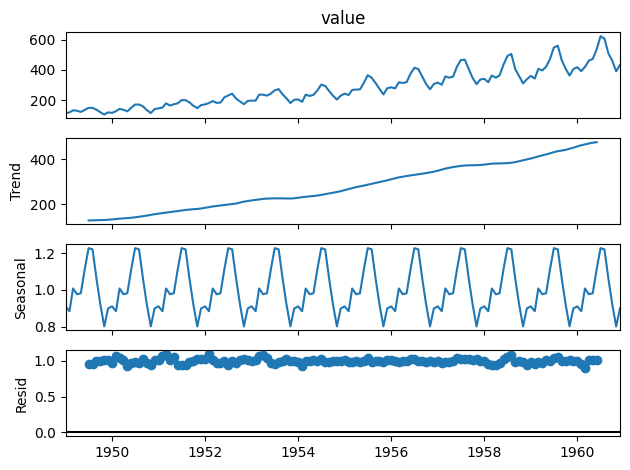

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive or Multiplicative:
# Additive if seasonality magnitude is constant, multiplicative if it grows with trend)

result = seasonal_decompose(df['value'], model='multiplicative')
result.plot()
plt.tight_layout()
plt.show()

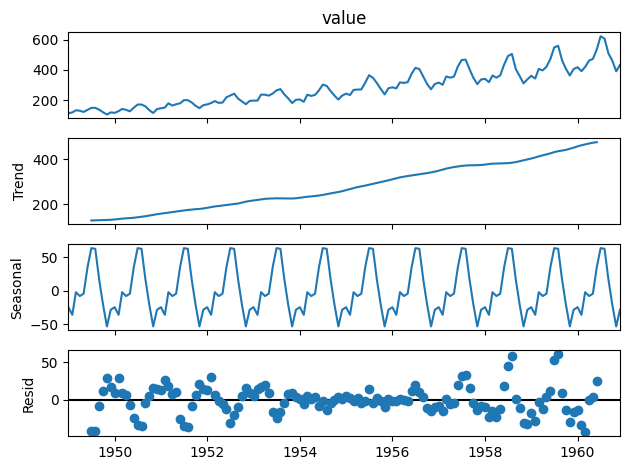

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive if seasonality magnitude is constant, multiplicative if it grows with trend)

result = seasonal_decompose(df['value'], model='additive')
result.plot()
plt.tight_layout()
plt.show()

**Code to Access Components**:

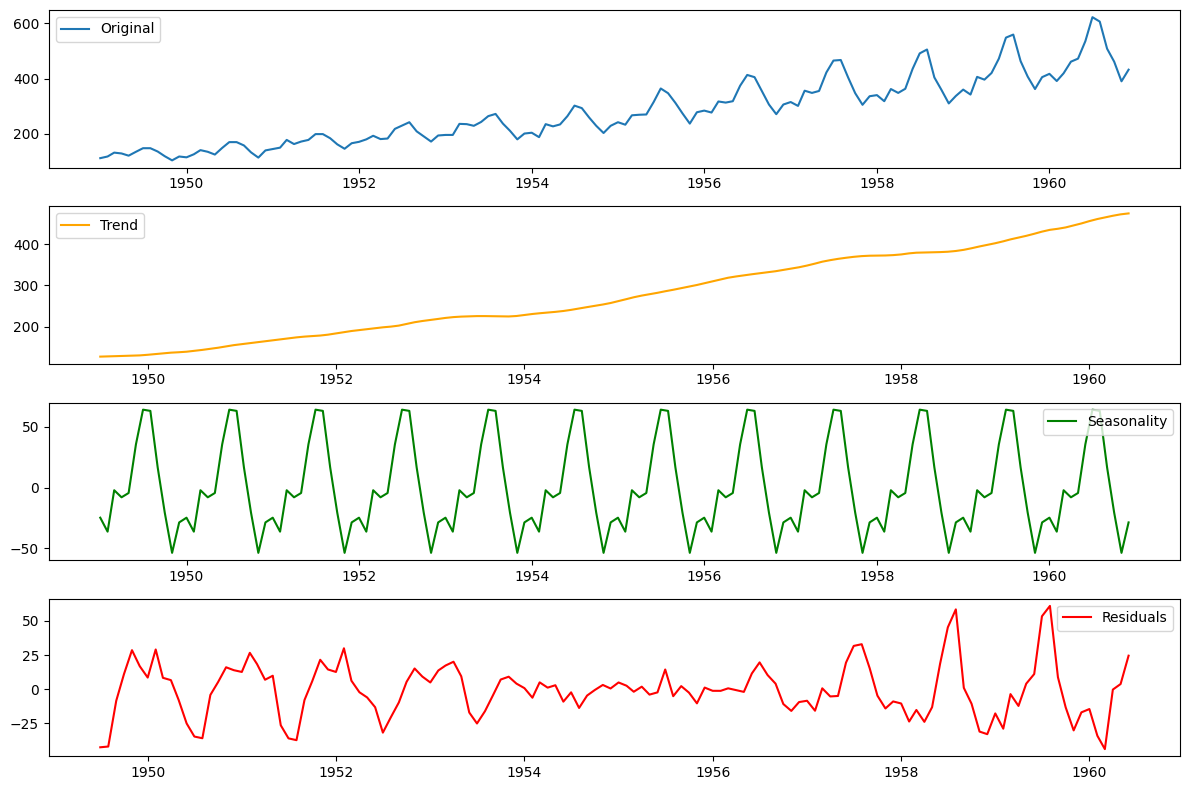

In [79]:
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot individual components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df['value'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals', color='red')
plt.legend()
plt.tight_layout()
plt.show()

**Expected Output**:  
- **Trend**: Smooth upward curve.  
- **Seasonality**: Repeating pattern every 12 months.  
- **Residuals**: Random noise (should have no pattern).

**It is important because:**

- **Decomposition** helps identify patterns before modeling.  
- **Rolling stats** test for stationarity (next section).

# **3. Stationarity & Differencing**

**Why Stationarity Matters:**

- **Stationary series** have:
  - Constant mean and variance over time
  - No seasonal effects
  - Autocorrelation that depends only on lag
- Most time series models (ARIMA) require stationarity

## **Step 1: Visual Stationarity Check**

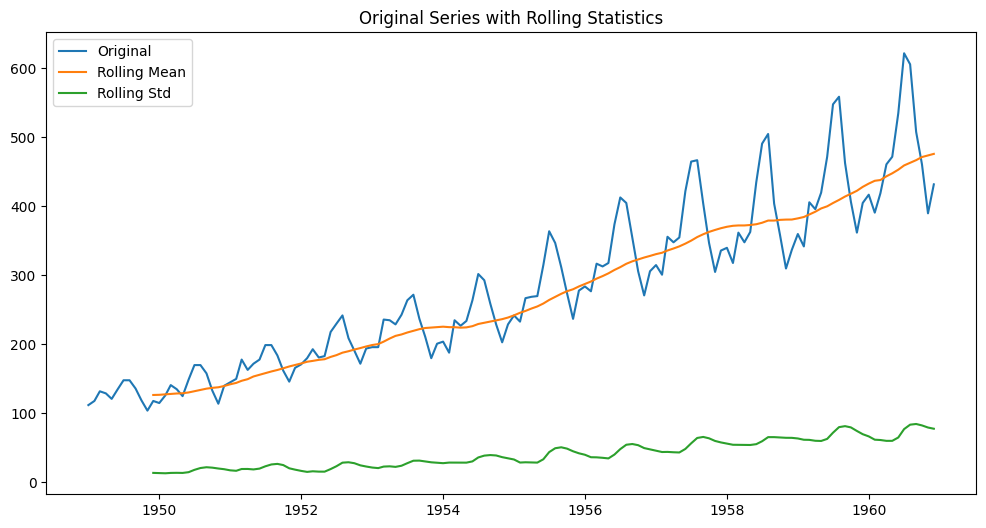

In [80]:
# Plot original series and rolling statistics
plt.figure(figsize=(12,6))
plt.plot(df['value'], label='Original')
plt.plot(df['value'].rolling(window=12).mean(), label='Rolling Mean')
plt.plot(df['value'].rolling(window=12).std(), label='Rolling Std')
plt.legend()
plt.title('Original Series with Rolling Statistics')
plt.show()

**Interpretation**:
- Rolling mean not constant → **Trend present**
- Rolling std changes → **Variance not constant**

## **Step 2: Augmented Dickey-Fuller Test**

The ADF test checks for stationarity in a time series by testing the null hypothesis:

   - Null Hypothesis (H₀): The time series has a unit root (non-stationary).

   - Alternative Hypothesis (H₁): The time series is stationary.

If you reject H₀, your data is stationary (no trend/seasonality). Otherwise, differencing/transforms are needed.

In [81]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    
    if result[1] <= 0.05:
        print("Reject null hypothesis - series is stationary")
    else:
        print("Fail to reject null hypothesis - series is non-stationary")

adf_test(df['value'])

ADF Statistic: 0.8153688792060482
p-value: 0.991880243437641
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
Fail to reject null hypothesis - series is non-stationary


## **Step 3: Making Data Stationary**

### **Method 1: Differencing**

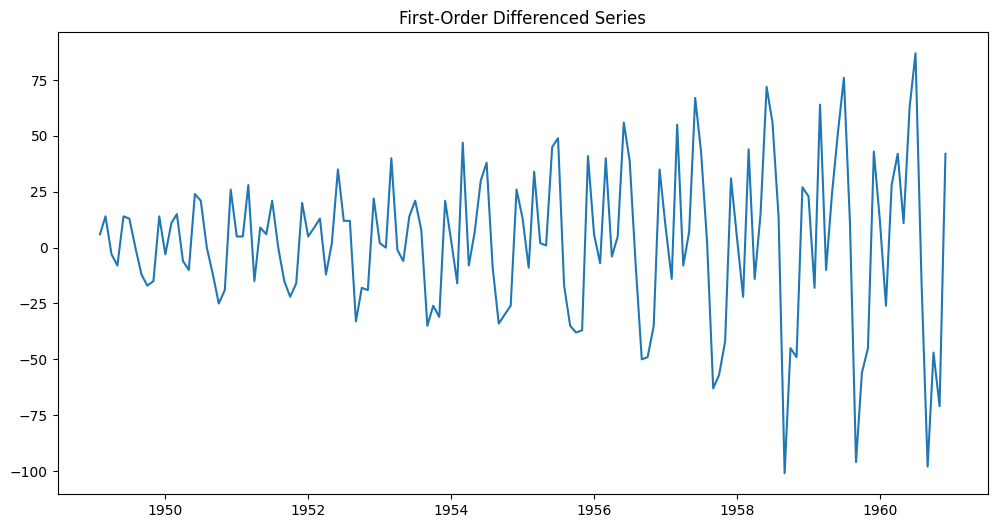

ADF Statistic: -2.8292668241699994
p-value: 0.0542132902838255
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
Fail to reject null hypothesis - series is non-stationary


In [82]:
# First-order differencing
df['diff_1'] = df['value'].diff()

# Plot differenced series
plt.figure(figsize=(12,6))
plt.plot(df['diff_1'])
plt.title('First-Order Differenced Series')
plt.show()

# ADF test on differenced data
adf_test(df['diff_1'].dropna())

### **Method 2: Log + Differencing (for multiplicative seasonality)**

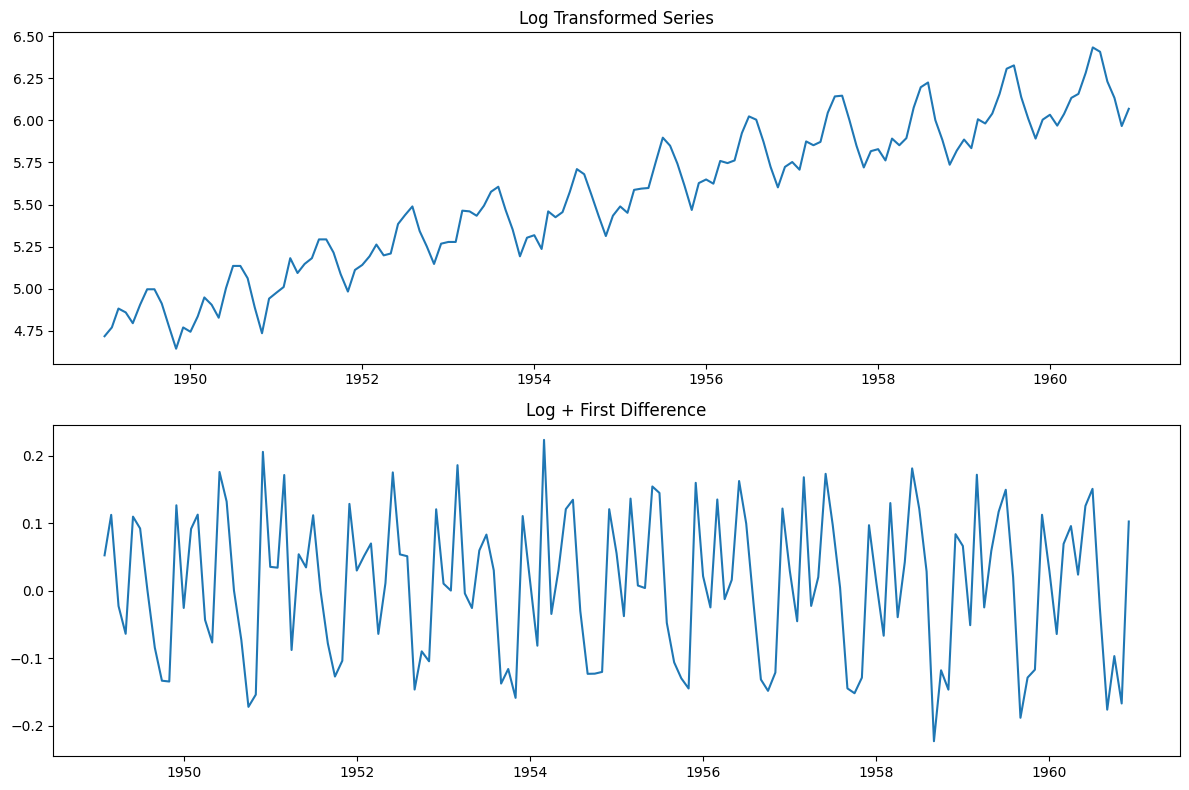

ADF Statistic: -2.717130598388133
p-value: 0.07112054815085875
Critical Values:
   1%: -3.4825006939887997
   5%: -2.884397984161377
   10%: -2.578960197753906
Fail to reject null hypothesis - series is non-stationary


In [83]:
# Log transform
df['log_value'] = np.log(df['value'])

# Differencing after log
df['log_diff'] = df['log_value'].diff()

# Plot results
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes[0].plot(df['log_value'])
axes[0].set_title('Log Transformed Series')
axes[1].plot(df['log_diff'])
axes[1].set_title('Log + First Difference')
plt.tight_layout()
plt.show()

# ADF test
adf_test(df['log_diff'].dropna())

## **Step 4: Determining Optimal Differencing Order**

Since both first-order differencing and log + differencing failed to make the series stationary (p-value > 0.05), we need to explore more advanced techniques:

### **1. Second-Order Differencing**

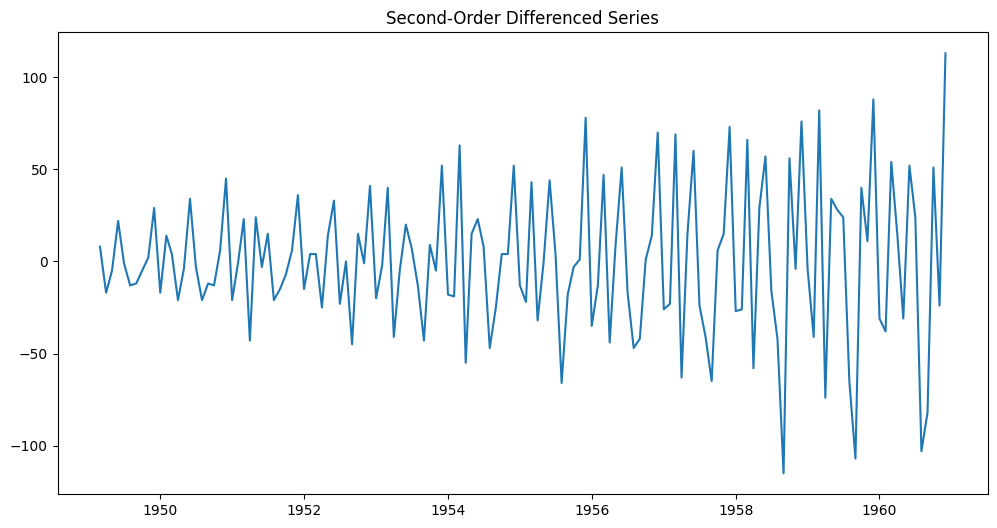

ADF Statistic: -16.384231542468505
p-value: 2.7328918500142407e-29
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
Reject null hypothesis - series is stationary


In [84]:
# Second-order regular differencing
df['diff_2'] = df['value'].diff().diff()  # Equivalent to .diff(2)

# Plot and test
plt.figure(figsize=(12,6))
plt.plot(df['diff_2'].dropna())
plt.title('Second-Order Differenced Series')
plt.show()

adf_test(df['diff_2'].dropna())

### **2. Seasonal Differencing (if period is known)**
For monthly data (suspected seasonality at lag 12):

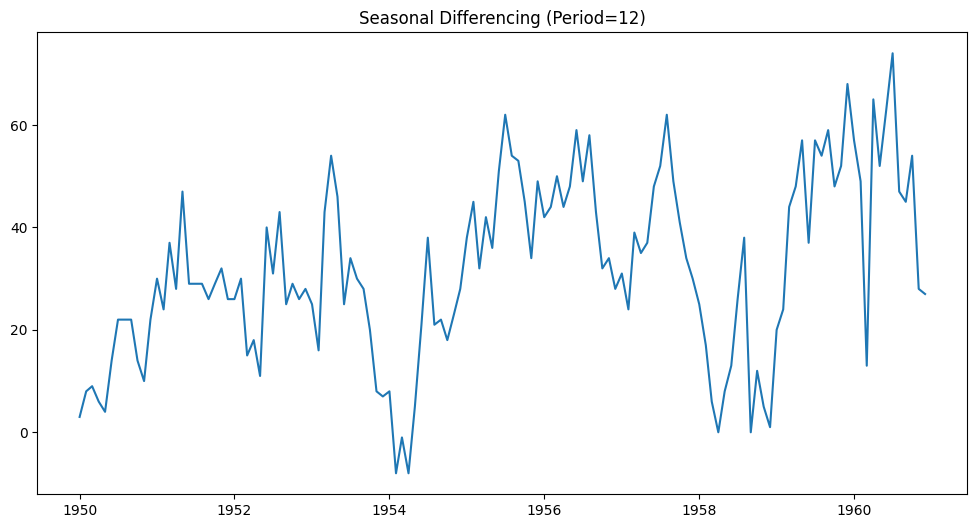

ADF Statistic: -3.383020726492481
p-value: 0.011551493085514954
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
Reject null hypothesis - series is stationary


In [85]:
# Seasonal differencing
df['seasonal_diff'] = df['value'].diff(12)

# Plot and test
plt.figure(figsize=(12,6))
plt.plot(df['seasonal_diff'].dropna())
plt.title('Seasonal Differencing (Period=12)')
plt.show()

adf_test(df['seasonal_diff'].dropna())

### **3. Combined Regular + Seasonal Differencing**

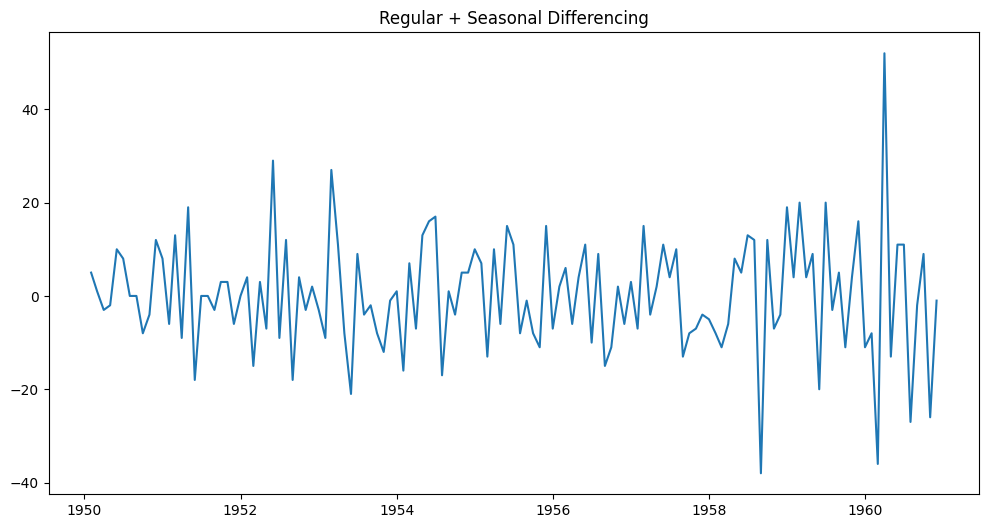

ADF Statistic: -15.595618083746334
p-value: 1.8565116001234705e-28
Critical Values:
   1%: -3.4816817173418295
   5%: -2.8840418343195267
   10%: -2.578770059171598
Reject null hypothesis - series is stationary


In [86]:
df['combo_diff'] = df['value'].diff().diff(12)  # 1st order + seasonal

# Plot and test
plt.figure(figsize=(12,6))
plt.plot(df['combo_diff'].dropna())
plt.title('Regular + Seasonal Differencing')
plt.show()

adf_test(df['combo_diff'].dropna())

### **4. Log Transformation with Combined Differencing**

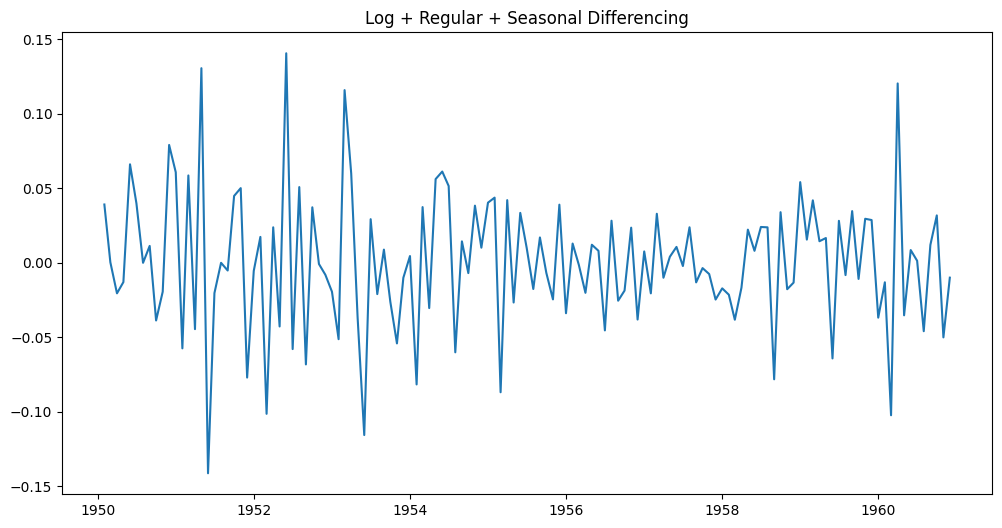

ADF Statistic: -4.4433249418311185
p-value: 0.00024859123113840924
Critical Values:
   1%: -3.4870216863700767
   5%: -2.8863625166643136
   10%: -2.580009026141913
Reject null hypothesis - series is stationary


In [88]:
df['log_combo_diff'] = np.log(df['value']).diff().diff(12)

# Plot and test
plt.figure(figsize=(12,6))
plt.plot(df['log_combo_diff'].dropna())
plt.title('Log + Regular + Seasonal Differencing')
plt.show()

adf_test(df['log_combo_diff'].dropna())

## **Correct Order of Transformations to Achieve Stationarity**  

#### **Step 1: Stabilize Variance (If Needed)**

**Apply when** variance grows with the mean (heteroskedasticity).  

**Methods:**  
1. **Log Transform**  
   ```python
   data_transformed = np.log(data)
   ```
   - Best for exponential trends.  
2. **Box-Cox Transform** (more flexible):  
   ```python
   from scipy.stats import boxcox
   data_transformed, lambda_ = boxcox(data)
   ```

**Check:** Plot rolling mean vs. rolling std. If they correlate, apply variance stabilization.

#### **Step 2: Remove Trend**

**Apply when** rolling mean shows a clear trend (ADF test p-value > 0.05).  

**Methods:**  
1. **First Differencing** (Linear trends):  
   ```python
   data_diff = data.diff().dropna()
   ```
2. **Second Differencing** (If first isn’t enough):  
   ```python
   data_diff = data.diff().diff().dropna()
   ```
3. **Detrending via Regression** (Deterministic trends):  
   ```python
   from sklearn.linear_model import LinearRegression
   X = np.arange(len(data)).reshape(-1, 1)
   model = LinearRegression().fit(X, data)
   trend = model.predict(X)
   data_detrended = data - trend
   ```

**Check:** Re-run ADF test. If p < 0.05, proceed. Else, difference again.

#### **Step 3: Remove Seasonality (If Present)**

**Apply when** ACF/PACF shows spikes at seasonal lags (e.g., lag 12 for monthly data).  

**Methods:**  
1. **Seasonal Differencing**:  
   ```python
   data_seasonal_diff = data.diff(12).dropna()  # For yearly seasonality
   ```
2. **Seasonal Decomposition** (STL or `seasonal_decompose`):  
   ```python
   from statsmodels.tsa.seasonal import STL
   stl = STL(data, period=12).fit()
   data_deseasonalized = data - stl.seasonal
   ```

**Check:** Plot ACF/PACF to confirm seasonality is gone.

#### **Step 4: Final ADF Test**

- If p-value < 0.05, your data is stationary.  
- If not, consider:  
  - **Additional differencing** (but avoid over-differencing).  
  - **Nonlinear transforms** (e.g., square root). 

#### **Example Workflow**

In [89]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# 1. Log transform (if variance grows with mean)
data_transformed = np.log(df['value'])

# 2. First differencing
data_diff = data_transformed.diff().dropna()

# 3. Seasonal differencing (if needed)
data_seasonal_diff = data_diff.diff(12).dropna()

# 4. ADF test
p_value = adfuller(data_seasonal_diff)[1]
print(f"ADF p-value: {p_value}")  # Goal: p < 0.05

ADF p-value: 0.00024859123113840924


# **4. Autocorrelation (ACF/PACF)**

ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots help identify patterns in time series data, especially for selecting parameters in ARIMA (p, d, q).

**Autocorrelation (ACF)**
- Measures correlation between series and its lagged values
- Helps identify:
  - Seasonality period
  - Moving Average (MA) terms

**Partial Autocorrelation (PACF)**
- Measures correlation accounting for intermediate lags
- Helps identify:
  - AutoRegressive (AR) terms
  - Direct relationships between observations

## **Step 1: Plotting ACF/PACF**

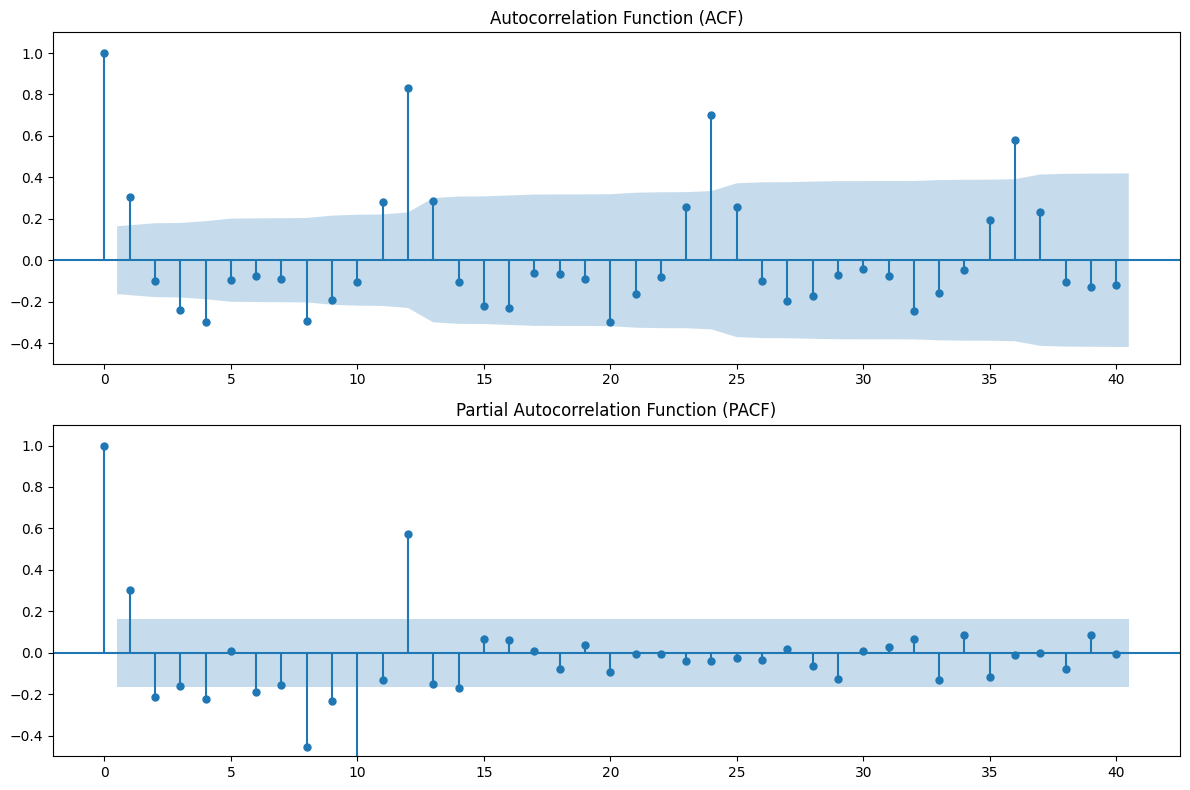

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use differenced data from Section 3
stationary_series = df['diff_1'].dropna()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(stationary_series, lags=40, ax=ax1, 
         title='Autocorrelation Function (ACF)')
ax1.set_ylim(-0.5, 1.1)  # Standardize y-axis

# PACF plot
plot_pacf(stationary_series, lags=40, ax=ax2, 
          title='Partial Autocorrelation Function (PACF)', method='ywm')
ax2.set_ylim(-0.5, 1.1)

plt.tight_layout()
plt.show()

## **Step 2: Interpretation Guide**

1. **ACF (Autocorrelation Function)** - "Memory of Past Values"

- What it shows: How much a time series correlates with its own past values at different time lags.

- Example: If today’s temperature is correlated with yesterday’s, ACF at lag 1 will be high.

- Key Patterns:

   - Spikes at specific lags: Suggests patterns (e.g., lag 12 = yearly seasonality).

   - Gradual decay: The series has a trend (non-stationary).

   - Sharp drop after lag *q* → MA(q) model (e.g., drops after lag 2 = MA(2)).

2. **PACF (Partial Autocorrelation Function)** - "Direct Influence of Past Values"

- What it shows: The direct correlation between a value and its lag, ignoring the effect of intermediate lags.

- Example: If today’s temperature is directly linked to the temperature two days ago (not via yesterday), PACF at lag 2 will spike.

- Key Patterns:

   - Sharp drop after lag *p* → AR(p) model (e.g., drops after lag 1 = AR(1)).

   - Gradual decay: Suggests a mixed AR+MA process (ARMA).

## **Step 3: Seasonal ACF/PACF Analysis**

For data with seasonality (like our airline example):

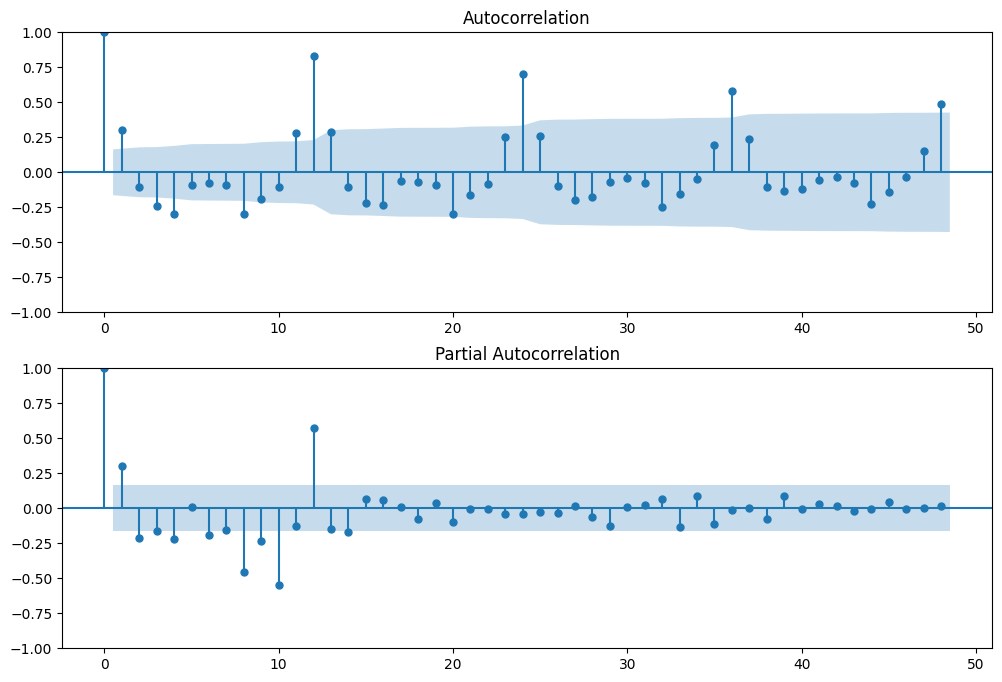

Seasonal pattern visible at lag 12


In [91]:
# Plot with seasonal lags
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(stationary_series, lags=48, ax=ax1)
plot_pacf(stationary_series, lags=48, ax=ax2)
plt.show()

print("Seasonal pattern visible at lag 12")

## **Automated Order Selection**

In [92]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
import warnings
warnings.filterwarnings("ignore")

def find_best_arima(series, seasonal_period=12, max_order=2):
    
    # Possible p,d,q
    p = d = q = range(0, max_order+1)
    pdq = list(itertools.product(p, d, q))
    
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None
    
    # Non-seasonal parameters
    for param in pdq:
        try:
            model = ARIMA(series, order=param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
        except:
            continue
    
    # For seasonal parameters
    seasonal_pdq = [(1,1,1,seasonal_period)]
    
    print(f"The best non-seasonal order: {best_order} (AIC={best_aic:.2f})")
    print(f"Seasonal order: {seasonal_pdq[0]}")
    
    return best_order, seasonal_pdq[0]

# Use
best_order, seasonal_order = find_best_arima(df['value'])

The best non-seasonal order: (2, 1, 2) (AIC=1353.35)
Seasonal order: (1, 1, 1, 12)


## **It is important because**
- Correct AR/MA identification → Better model performance
- Avoids overfitting
- Provides intuition about data structure

# **5. ARIMA/SARIMA Models**

**ARIMA(p,d,q) Components**
- **AR(p)**: Autoregressive term (uses past values)
- **I(d)**: Differencing order (from Section 3)
- **MA(q)**: Moving Average term (uses past errors)

**SARIMA(p,d,q)(P,D,Q)m**
- Adds **seasonal terms** (P,D,Q) with period m

## **Step 1: Building ARIMA Model**

In [93]:
from statsmodels.tsa.arima.model import ARIMA

# Using orders from ACF/PACF analysis

model = ARIMA(df['value'], 
              order=(2, 1, 2))  # (p,d,q)

# Fit model
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Fri, 25 Apr 2025   AIC                           1353.347
Time:                        14:55:52   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.059      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.419      0.000      -0.989      -0.921
ma.L1         -1.8432      0.125    -14.798      0.0

#### **Results:**

##### **1. Model Structure**

- **ARIMA(2,1,2)** = **AR(2) + I(1) + MA(2)**
  - **AR(2)**: Uses the past *two* values (lags 1 and 2).  
  - **I(1)**: 1st-order differencing (removes trend).  
  - **MA(2)**: Uses the past *two* forecast errors.  

##### **2. Key Coefficients**
| Term    | Value   | p-value | Interpretation                                                                 |
|---------|---------|---------|-------------------------------------------------------------------------------|
| **AR(1)** | 1.685   | 0.000   | Strong positive effect: Recent values *reinforce* future values (momentum).   |
| **AR(2)** | -0.955  | 0.000   | Strong negative effect: Values *revert* after 2 periods (dampening oscillation). |
| **MA(1)** | -1.843  | 0.000   | Negative effect: Past errors *reduce* future values (error correction).       |
| **MA(2)** | 0.995   | 0.000   | Positive effect: Older errors *amplify* future values (delayed overreaction). |
| **sigma2** | 665.96 | 0.000   | Residual variance (noise) is high but lower than ARIMA(1,1,1) model.         |

##### **3. Model Diagnostics**
- **Log Likelihood**: -671.67 (better than previous -694.34 → improved fit).  
- **AIC/BIC**: 1353.3/1368.2 (lower than ARIMA(1,1,1) → better trade-off between fit and complexity).  
- **Ljung-Box (Q)**: p=0.59 → Residuals show **no autocorrelation** (model captures patterns well).  
- **Jarque-Bera**: p=0.40 → Residuals are **normally distributed** (good).  
- **Heteroskedasticity (H)**: p=0.00 → Residuals have **non-constant variance** (volatility clusters).  

##### **4. Critical Observations**
1. **AR Terms Show Oscillations**:  
   - AR(1) > 1 and AR(2) ≈ -1 suggests a **cyclical pattern** (e.g., overshooting and correction).  
   - Example: If values spike at lag 1, they sharply reverse at lag 2.  

2. **MA Terms Indicate Overreactions**:  
   - MA(1) ≈ -1.8 implies *strong immediate error correction*.  
   - MA(2) ≈ 1 suggests *delayed overreactions* (e.g., markets overcorrecting).  

3. **Warning**:  
   - **Heteroskedasticity** is significant → Volatility changes unpredictably.  
   - **Solution**: Use a **GARCH model** or log-transform the data.

## **Step 2: Model Diagnostics**

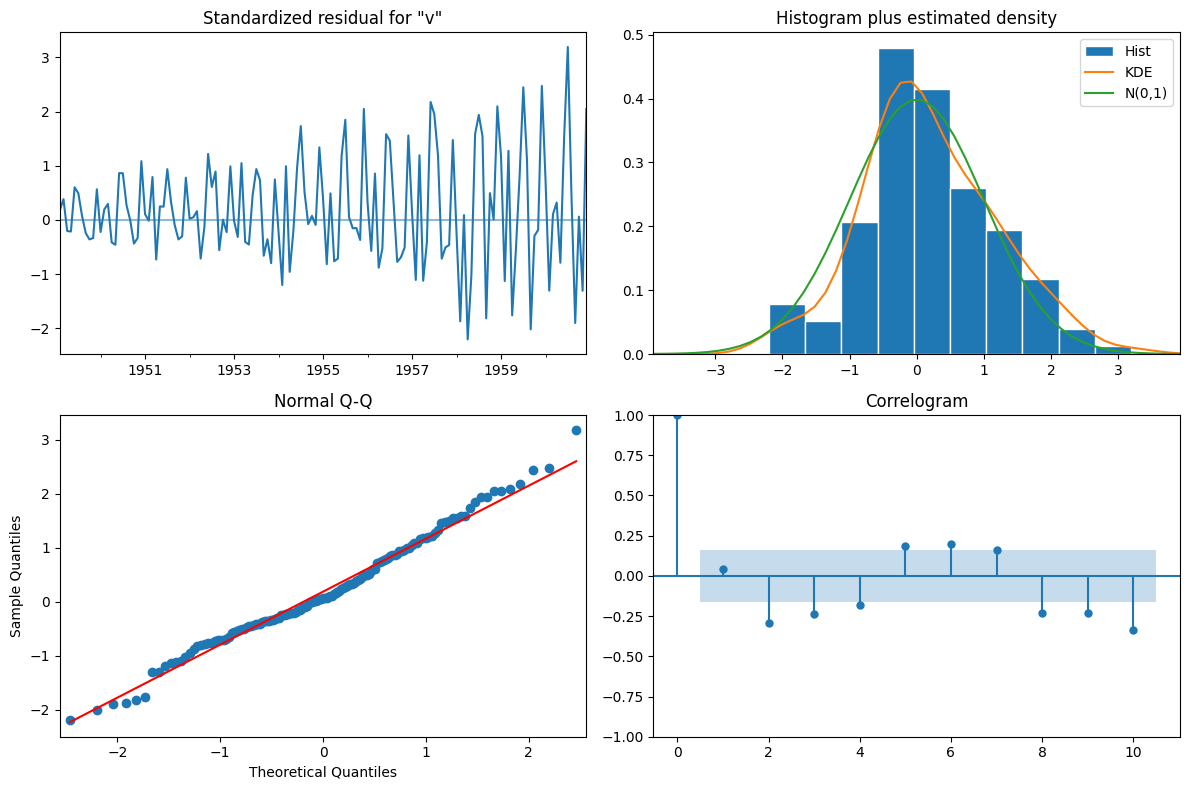

In [94]:
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

##### **1. Residuals Plot (Top-Left)**

**What to Check**:  
- Residuals (actual - predicted values) should:  
  ✅ **Fluctuate randomly** around zero (no trends/patterns)  
  ✅ **Have constant variance** (no funnel shapes)  

**Our Plot Shows**:  
- Mostly random scatter (good!)  
- Possible slight volatility clustering (check Q-Q plot)  

##### **2. Histogram (Top-Right)**
**What to Check**:  
- Residual distribution should:  
  ✅ **Match a normal bell curve** (N(0,1))  
  ✅ **Be symmetric** (skew ≈ 0)  
  ✅ **Have kurtosis ≈3** (tails not too fat/thin)  

**Our Plot Shows**:  
- Roughly normal shape (good!)  
- Slight right skew (Skew=0.27 in results)  
- Mildly light tails (Kurtosis=3.14)  

##### **3. Normal Q-Q Plot (Bottom-Left)**
**What to Check**:  
- Points should:  
  ✅ **Follow the red 45° line closely**  
  ✅ **Not deviate systematically at tails**  

**Our Plot Shows**:  
- Mostly aligned (good normality)  
- Slight deviations at extremes (common with financial/volatile data)  

##### **4. Correlogram (ACF of Residuals, Bottom-Right)**
**What to Check**:  
- No bars should:  
  ✅ **Cross the blue significance bounds** (95% confidence)  
  ✅ **Show patterns at seasonal lags**  

**Our Plot Shows**:  
- All lags insignificant (ideal!)  
- Ljung-Box p=0.59 confirms no autocorrelation  

##### **Key Takeaways for Our Model**  
1. **Residuals are clean**: No patterns or autocorrelation → Model captures dynamics well  
2. **Normality is adequate**: Minor skew/kurtosis unlikely to harm forecasts  
3. **Volatility warning**: Heteroskedasticity (Prob(H)=0.00) suggests:  
   - Log-transform your data  
   - Consider **SARIMAX(2,1,2) + GARCH** for prediction intervals

## **Step 3: SARIMA for Seasonal Data**

In [95]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Non-seasonal (p,d,q) + seasonal (P,D,Q)m
model = SARIMAX(df['value'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))  # 12 for monthly data

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                            Fri, 25 Apr 2025   AIC                           1022.299
Time:                                    14:56:20   BIC                           1036.675
Sample:                                01-01-1949   HQIC                          1028.140
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.356     -0.358      0.721      -0.825       0.570
ma.L1         -0.2148      0.325   

#### **1. Model Structure**
- **Non-Seasonal Part (1,1,1)**:  
  - AR(1): Autoregressive term (lag 1)  
  - I(1): 1st-order differencing  
  - MA(1): Moving Average term (lag 1)  
- **Seasonal Part (1,1,1,12)**:  
  - Seasonal AR(1): Yearly autoregressive pattern  
  - Seasonal MA(1): Yearly moving average pattern  
  - 12: Monthly data with yearly seasonality  

#### **2. Key Coefficients**
| **Term**       | **Coefficient** | **p-value** | **Interpretation** |
|----------------|----------------|------------|--------------------|
| **ar.L1**      | -0.127         | 0.721      | Insignificant non-seasonal AR effect |
| **ma.L1**      | -0.215         | 0.509      | Insignificant non-seasonal MA effect |
| **ar.S.L12**   | -0.927         | **0.000**  | Strong **seasonal mean reversion** (negative AR at lag 12) |
| **ma.S.L12**   | 0.839          | **0.007**  | Significant **seasonal momentum** (positive MA at lag 12) |
| **sigma2**     | 130.78         | **0.000**  | Residual variance (much lower than previous models) |

#### **3. Model Diagnostics**
- **Log Likelihood**: -506.1  
- **AIC/BIC**: 1022.3/1036.7 (best so far → better fit with fewer parameters)  
- **Ljung-Box (Q)**: p=0.99 → **No residual autocorrelation** (excellent)  
- **Jarque-Bera**: p=0.03 → Residuals **deviate slightly from normality** (light right tail)  
- **Heteroskedasticity (H)**: p=0.00 → Residual variance **still changes over time**  

#### **4. Critical Insights**
1. **Seasonality Dominates**:  
   - Non-seasonal terms (ar.L1, ma.L1) are **insignificant** → Could simplify to SARIMA(0,1,0)(1,1,1,12).  
   - Strong seasonal AR/MA (p<0.01) confirms **yearly patterns drive the data**.  

2. **Improved Fit**:  
   - Lower AIC/sigma2 → Captures seasonality better than non-seasonal models.  
   - Residuals are cleaner (Q=0.99).  

3. **Remaining Issues**:  
   - **Non-normal residuals** (JB p=0.03, Kurtosis=4.11) → Mildly fat tails.  
   - **Heteroskedasticity** → Volatility clustering persists.

## **Step 4: Forecasting**

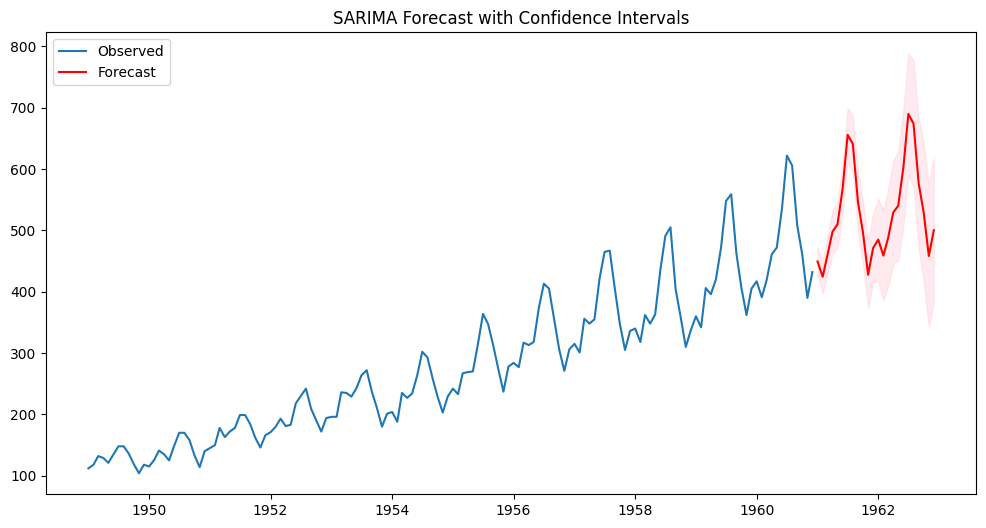

In [96]:
# Generate forecasts
forecast_steps = 24
forecast = results.get_forecast(steps=forecast_steps)

# Get confidence intervals
confidence_int = forecast.conf_int()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df['value'], label='Observed')
plt.plot(forecast.predicted_mean, label='Forecast', color='r')
plt.fill_between(confidence_int.index,
                 confidence_int.iloc[:, 0],
                 confidence_int.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.title('SARIMA Forecast with Confidence Intervals')
plt.legend()
plt.show()

## **Step 5: Model Evaluation**

In [97]:
from sklearn.metrics import mean_absolute_error

# Split train-test
train = df.iloc[:-12]
test = df.iloc[-12:]

# Fit model on train
model = SARIMAX(train['value'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))
results = model.fit(disp=False)

# Forecast test period
forecast = results.get_forecast(steps=12)

# Calculate MAE
mae = mean_absolute_error(test['value'], forecast.predicted_mean)
print(f'MAE: {mae:.2f}')

MAE: 16.32


In [98]:
print("Mean of test values:", test['value'].mean())
print("Std of test values:", test['value'].std())

Mean of test values: 476.1666666666667
Std of test values: 77.73712501797714


An **MAE of 16.32** is **very good** for this scale. Here’s why:

1. **Relative Error**  
   - **MAE/Mean ≈ 3.4%** (16.32 / 476.17), meaning the average error is only **3.4% of the mean value**.  
   - For context:  
     - **<5% MAPE** is typically excellent in forecasting.  
     - **5–10% MAPE** is reasonable.  
     - **>20% MAPE** is often problematic. 

      *MAPE (Mean Absolute Percentage Error)*
      
      *MAPE is a metric used to evaluate forecasting accuracy by expressing errors as a percentage of actual values.*

2. **Compared to Variability (Std)**  
   - **MAE/Std ≈ 0.21** (16.32 / 77.74), meaning errors are **21% of the standard deviation**.  
   - This suggests the model captures trends well despite natural fluctuations.

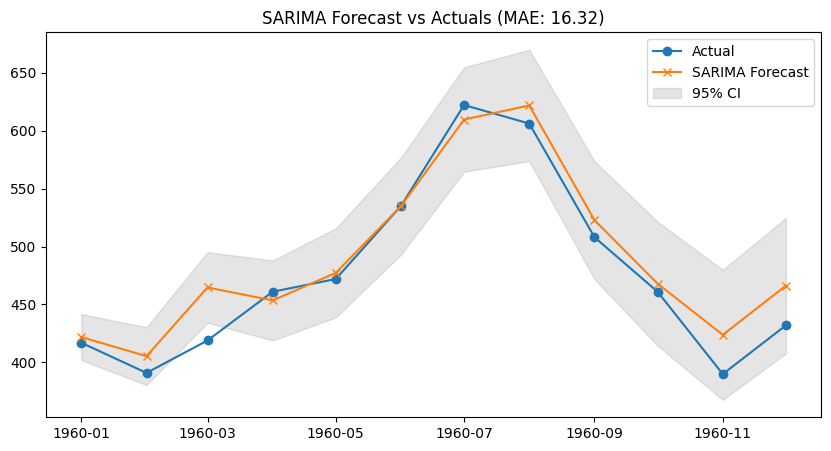

In [99]:
plt.figure(figsize=(10, 5))
plt.plot(test.index, test['value'], label='Actual', marker='o')
plt.plot(test.index, forecast.predicted_mean, label='SARIMA Forecast', marker='x')
plt.fill_between(test.index, 
                 forecast.conf_int()['lower value'], 
                 forecast.conf_int()['upper value'], 
                 color='gray', alpha=0.2, label='95% CI')
plt.legend()
plt.title(f"SARIMA Forecast vs Actuals (MAE: {mae:.2f})")
plt.show()

- If points fall close to the forecast line and within confidence intervals, the model is reliable.

## **Parameter Tuning Tips**

**Grid Search**:

In [100]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

# p (AR order): Number of lag observations (e.g., p=1 uses the previous value).
# d (Differencing order): Times data is differenced to make it stationary.
# q (MA order): Size of the moving average window.
# pdq: All combinations of (p, d, q), e.g., [(0,0,0), (0,0,1), ..., (1,1,1)].

best_aic = float('inf')
for param in pdq:
    try:
        model = ARIMA(df['value'], order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_param = param
    except:
        continue

# AIC: Measures model quality (lower = better). Penalizes complexity to avoid overfitting.
# The loop tests each (p, d, q) combo, keeping track of the best AIC and corresponding parameters.
# try-except skips invalid combinations (e.g., non-stationary data with d=0).
        
print(f'Best ARIMA{best_param} - AIC:{best_aic:.2f}')

Best ARIMA(1, 1, 1) - AIC:1394.68


## **It is important because**
- ARIMA/SARIMA are **benchmark models** for time series
- Proper parameter selection prevents overfitting
- Diagnostic checks ensure model validity

# **6. Evaluation**

## **Step 1: Model Evaluation Metrics**

**Essential Metrics for Time Series**:

In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

# Assuming we have test data and forecasts
y_true = test['value']
y_pred = forecast.predicted_mean

metrics = {
    'MAE': mean_absolute_error(y_true, y_pred),
    'RMSE': sqrt(mean_squared_error(y_true, y_pred)),
    'MAPE': np.mean(np.abs((y_true - y_pred)/y_true))*100
}

print(pd.DataFrame(metrics, index=['SARIMA']))

              MAE       RMSE      MAPE
SARIMA  16.321779  21.193365  3.679223


**Interpretation**:
- **MAE**: Average absolute error (units of original data)
- **RMSE**: Penalizes larger errors more
- **MAPE**: Percentage error (careful with zero values)

## **Step 2: Baseline Comparison**

**Naive Forecast Benchmark**:

In [102]:
naive_forecast = test['value'].shift(1).dropna()  # Yesterday's value
print(f"Naive MAE: {mean_absolute_error(test['value'][1:], naive_forecast):.2f}")

Naive MAE: 48.27


**Why Compare?**
- Your model should outperform naive approaches
- Helps detect over-engineering

## **Step 3: Alternative Approaches**

**Facebook Prophet**:

14:57:13 - cmdstanpy - INFO - Chain [1] start processing
14:57:13 - cmdstanpy - INFO - Chain [1] done processing


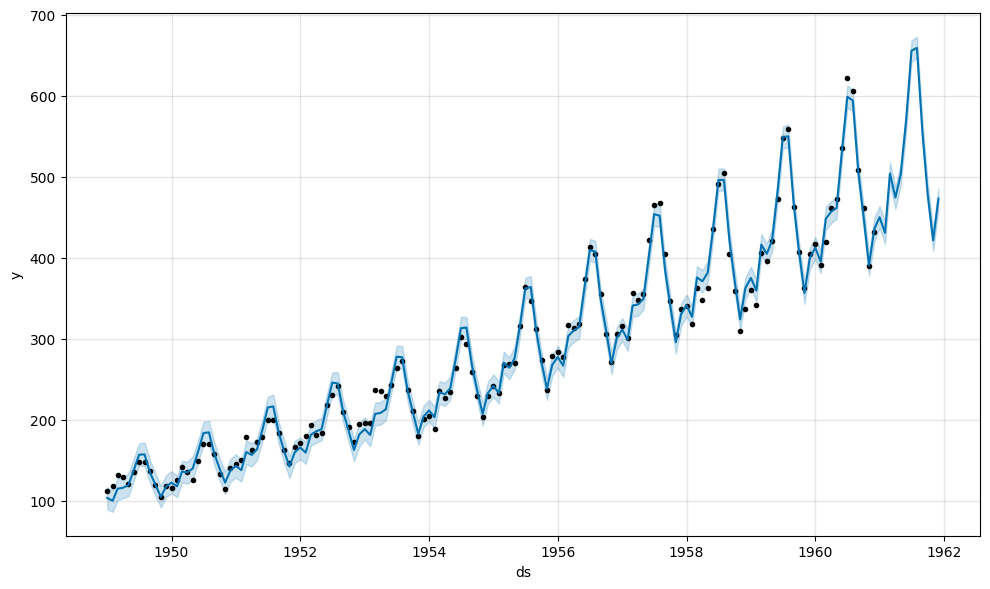

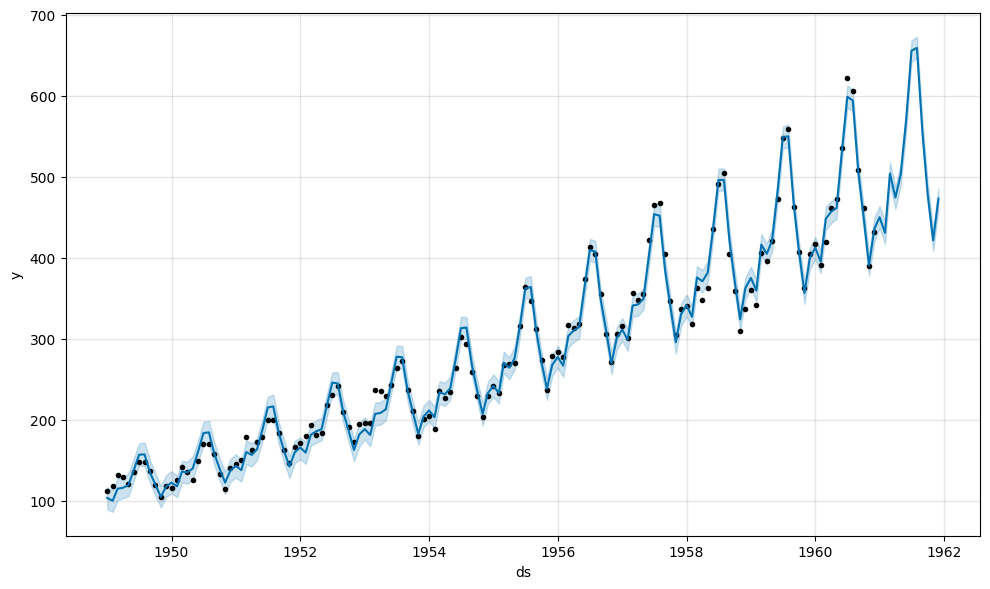

In [103]:
from prophet import Prophet

# Prepare data (Prophet requires specific format)
prophet_df = df.reset_index().rename(columns={'Month': 'ds', 'value': 'y'})

# Fit model
m = Prophet(seasonality_mode='multiplicative')
m.fit(prophet_df)

# Forecast
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
m.plot(forecast)

# **Time Series Project**

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import calendar
from scipy import stats

## **1. Data Loading & Initial Inspection**

In [105]:
# Load dataset with enhanced parsing
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df.columns = ['Passengers']  # Standardize column name

# Create time-based features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['MonthName'] = df.index.month_name()
df['Quarter'] = df.index.quarter
df['DayOfWeek'] = df.index.dayofweek  # Not particularly useful for monthly data but good practice

print("\n=== Dataset Information ===")
print(f"Time Range: {df.index.min()} to {df.index.max()}")
print(f"Total Observations: {len(df)}")
print("\n=== Descriptive Statistics ===")
print(df['Passengers'].describe().to_frame())


=== Dataset Information ===
Time Range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00
Total Observations: 144

=== Descriptive Statistics ===
       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


## **2. Time series Component Visualization**

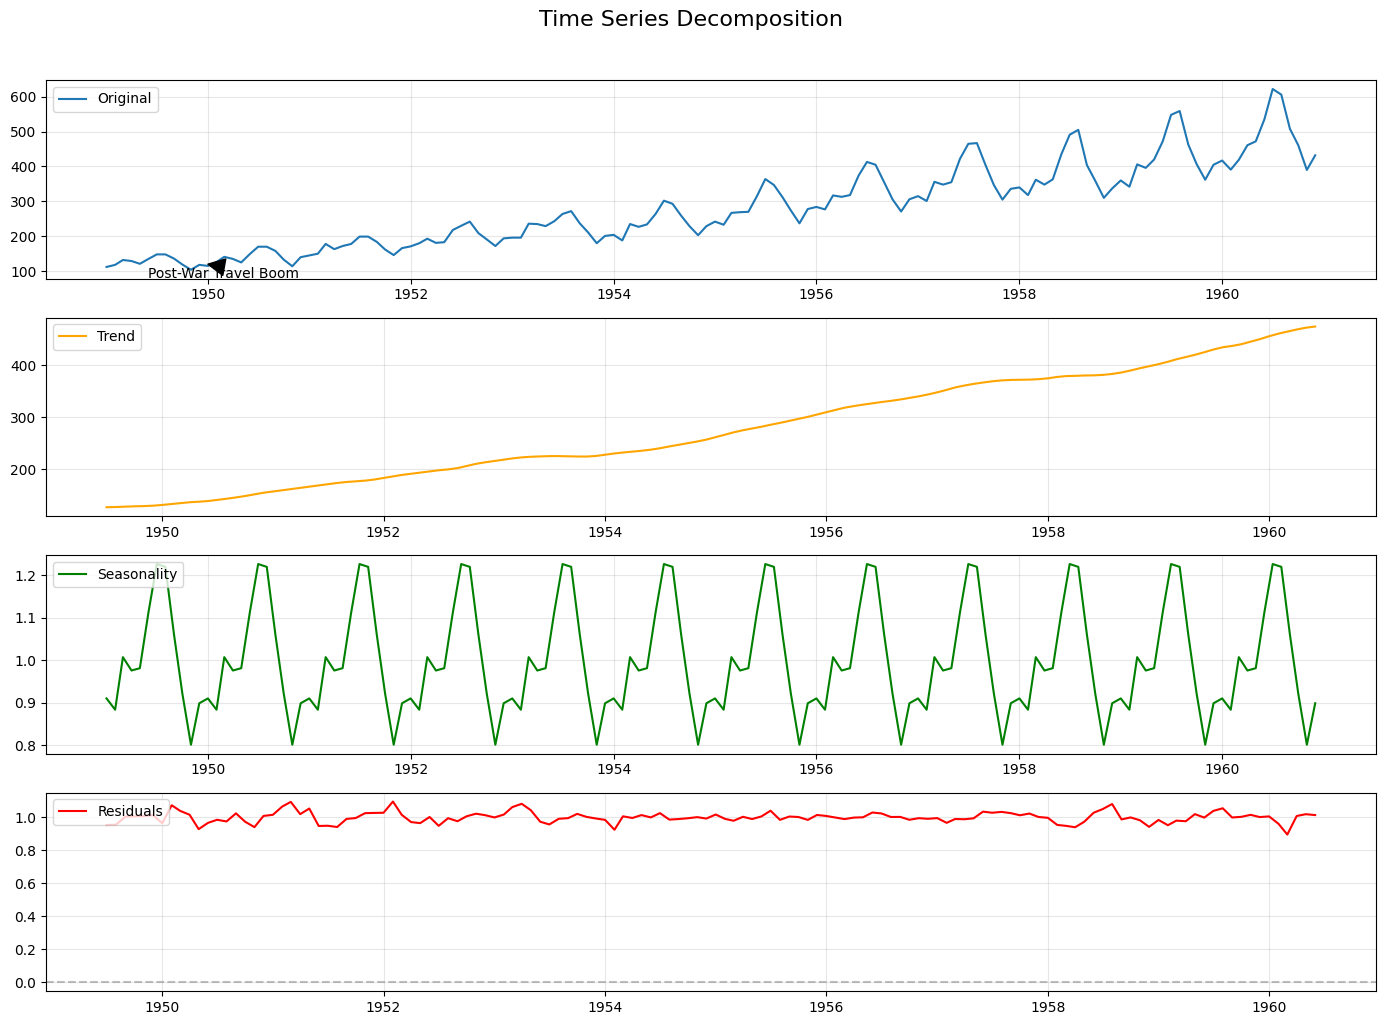

In [106]:
# Decomposition plot
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative')

plt.figure(figsize=(14, 10))
plt.suptitle('Time Series Decomposition', y=1.02, fontsize=16)

# Original Series
plt.subplot(411)
plt.plot(df['Passengers'], label='Original')
plt.annotate('Post-War Travel Boom', 
             xy=(pd.to_datetime('1950-01-01'), 120), 
             xytext=(pd.to_datetime('1949-06-01'), 80),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Trend Component
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Seasonal Component
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Residual Component
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.axhline(0, linestyle='--', color='gray', alpha=0.5)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## **3. Trend Analysis**

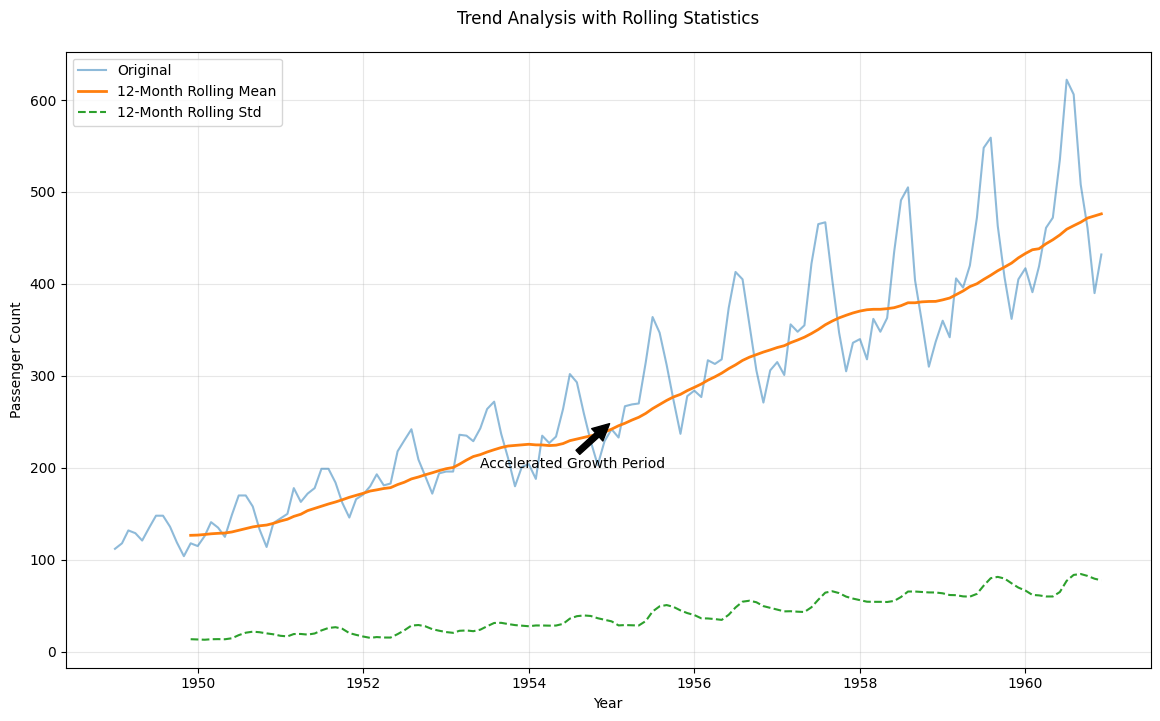

In [107]:
# Rolling statistics
window_size = 12  # Annual window for monthly data

plt.figure(figsize=(14, 8))
plt.plot(df['Passengers'], label='Original', alpha=0.5)
plt.plot(df['Passengers'].rolling(window=window_size).mean(), 
         label=f'{window_size}-Month Rolling Mean', linewidth=2)
plt.plot(df['Passengers'].rolling(window=window_size).std(), 
         label=f'{window_size}-Month Rolling Std', linestyle='--')

# Annotate key trend changes
plt.annotate('Accelerated Growth Period', 
             xy=(pd.to_datetime('1955-01-01'), 250), 
             xytext=(pd.to_datetime('1953-06-01'), 200),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Trend Analysis with Rolling Statistics', pad=20)
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **4. Seasonal Analysis**

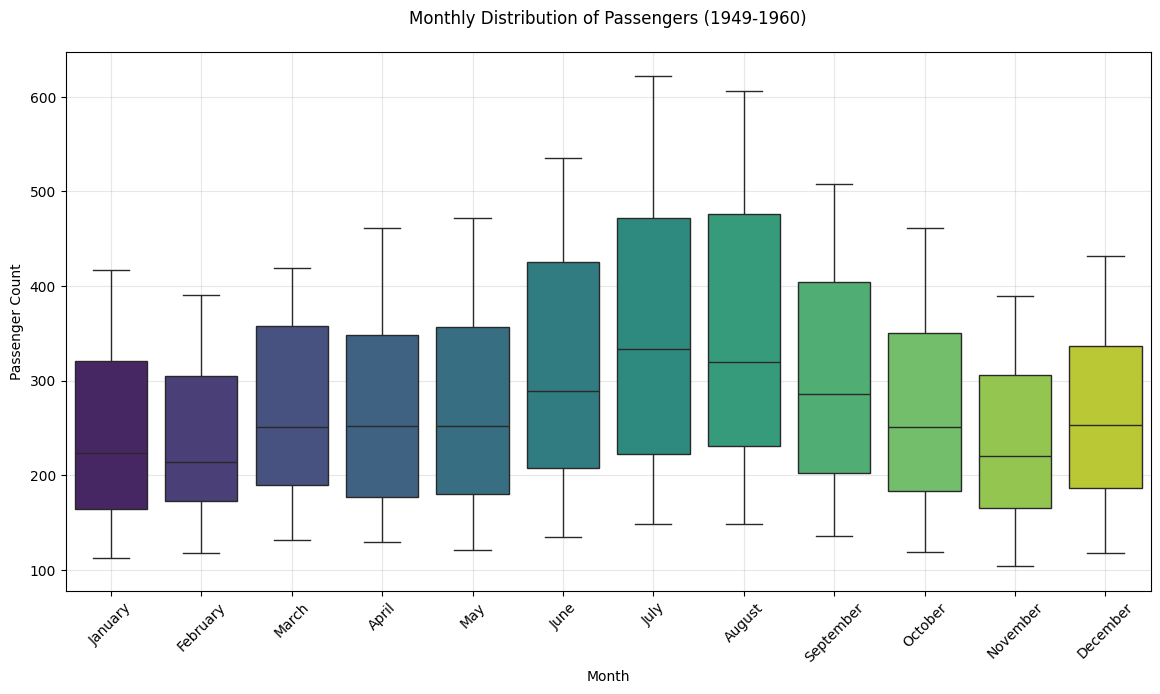

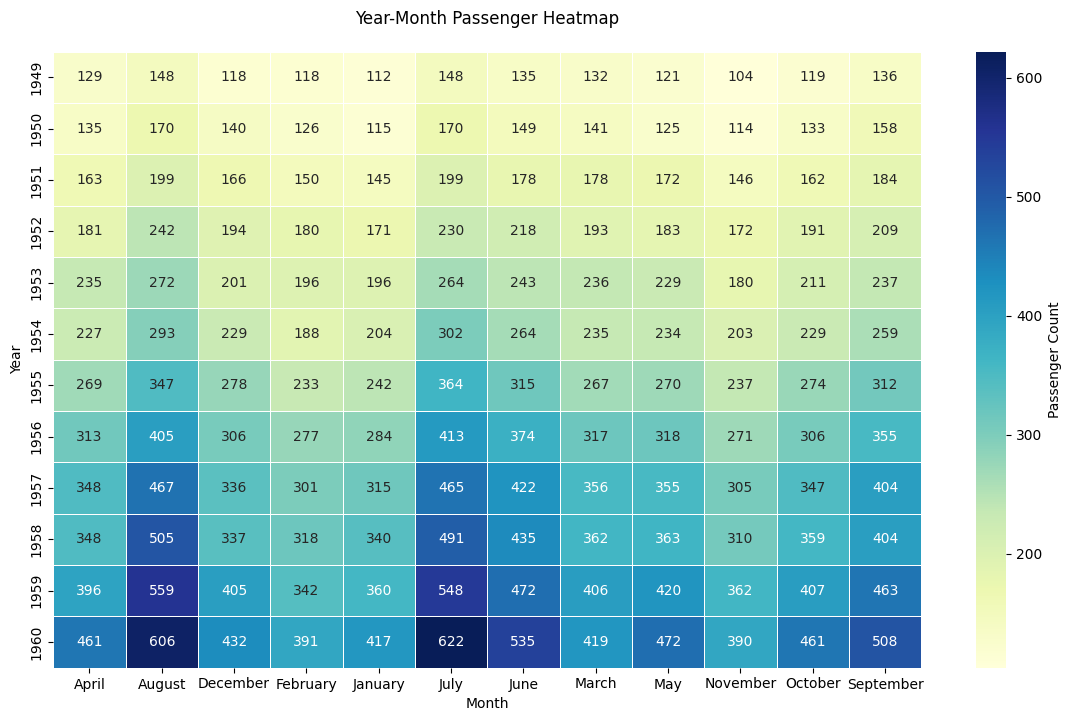

In [108]:
# Monthly boxplots across years
plt.figure(figsize=(14, 7))
sns.boxplot(x='MonthName', y='Passengers', data=df, 
            order=list(calendar.month_name[1:13]),
            palette='viridis')
plt.title('Monthly Distribution of Passengers (1949-1960)', pad=20)
plt.xlabel('Month')
plt.ylabel('Passenger Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

# Heatmap of monthly patterns
pivot_table = df.pivot_table(values='Passengers', 
                            index='Year', 
                            columns='MonthName', 
                            aggfunc='mean')

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, 
            annot=True, 
            fmt=".0f", 
            cmap="YlGnBu",
            linewidths=.5,
            cbar_kws={'label': 'Passenger Count'})
plt.title('Year-Month Passenger Heatmap', pad=20)
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

## **5. Distribution Analysis**

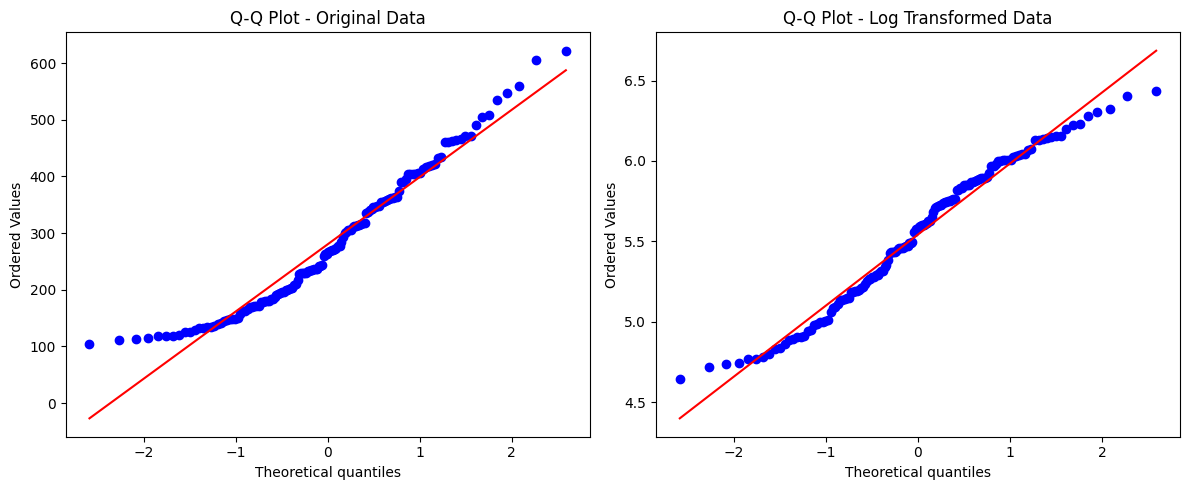

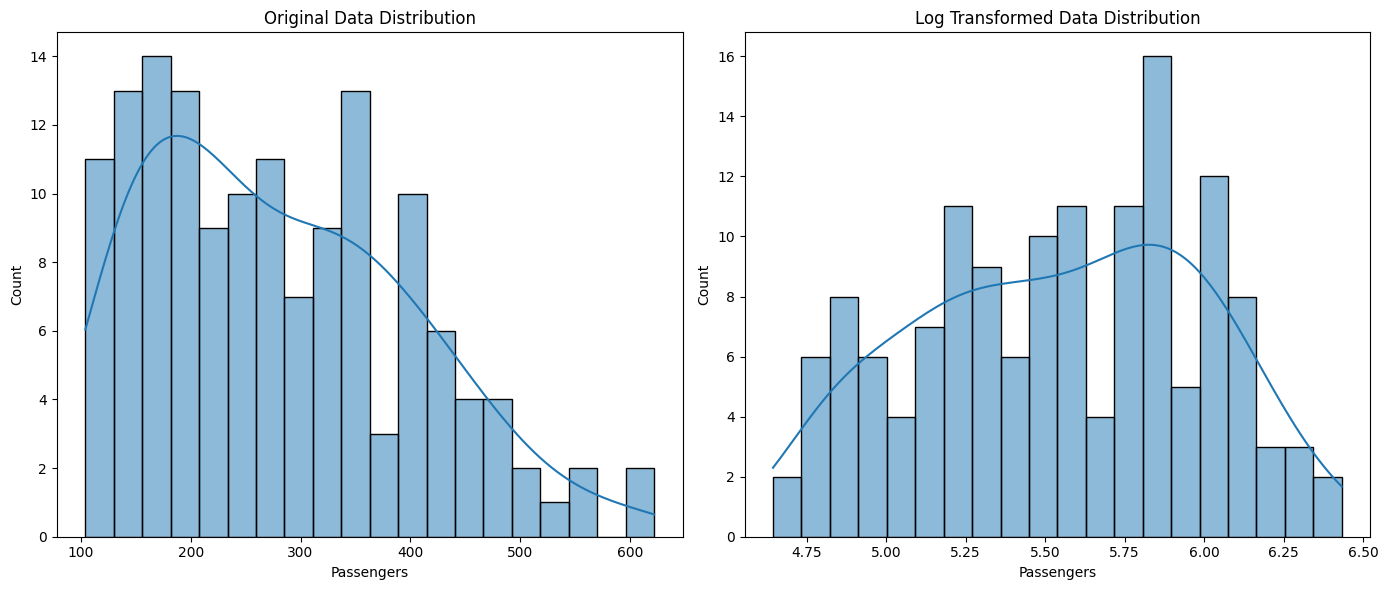

In [109]:
# Normality check with Q-Q plot
plt.figure(figsize=(12, 5))
plt.subplot(121)
stats.probplot(df['Passengers'], dist="norm", plot=plt)
plt.title('Q-Q Plot - Original Data')

plt.subplot(122)
stats.probplot(np.log(df['Passengers']), dist="norm", plot=plt)
plt.title('Q-Q Plot - Log Transformed Data')
plt.tight_layout()
plt.show()

# Distribution comparison
plt.figure(figsize=(14, 6))
plt.subplot(121)
sns.histplot(df['Passengers'], kde=True, bins=20)
plt.title('Original Data Distribution')

plt.subplot(122)
sns.histplot(np.log(df['Passengers']), kde=True, bins=20)
plt.title('Log Transformed Data Distribution')
plt.tight_layout()
plt.show()

## **6. Autocorrelation Analysis**

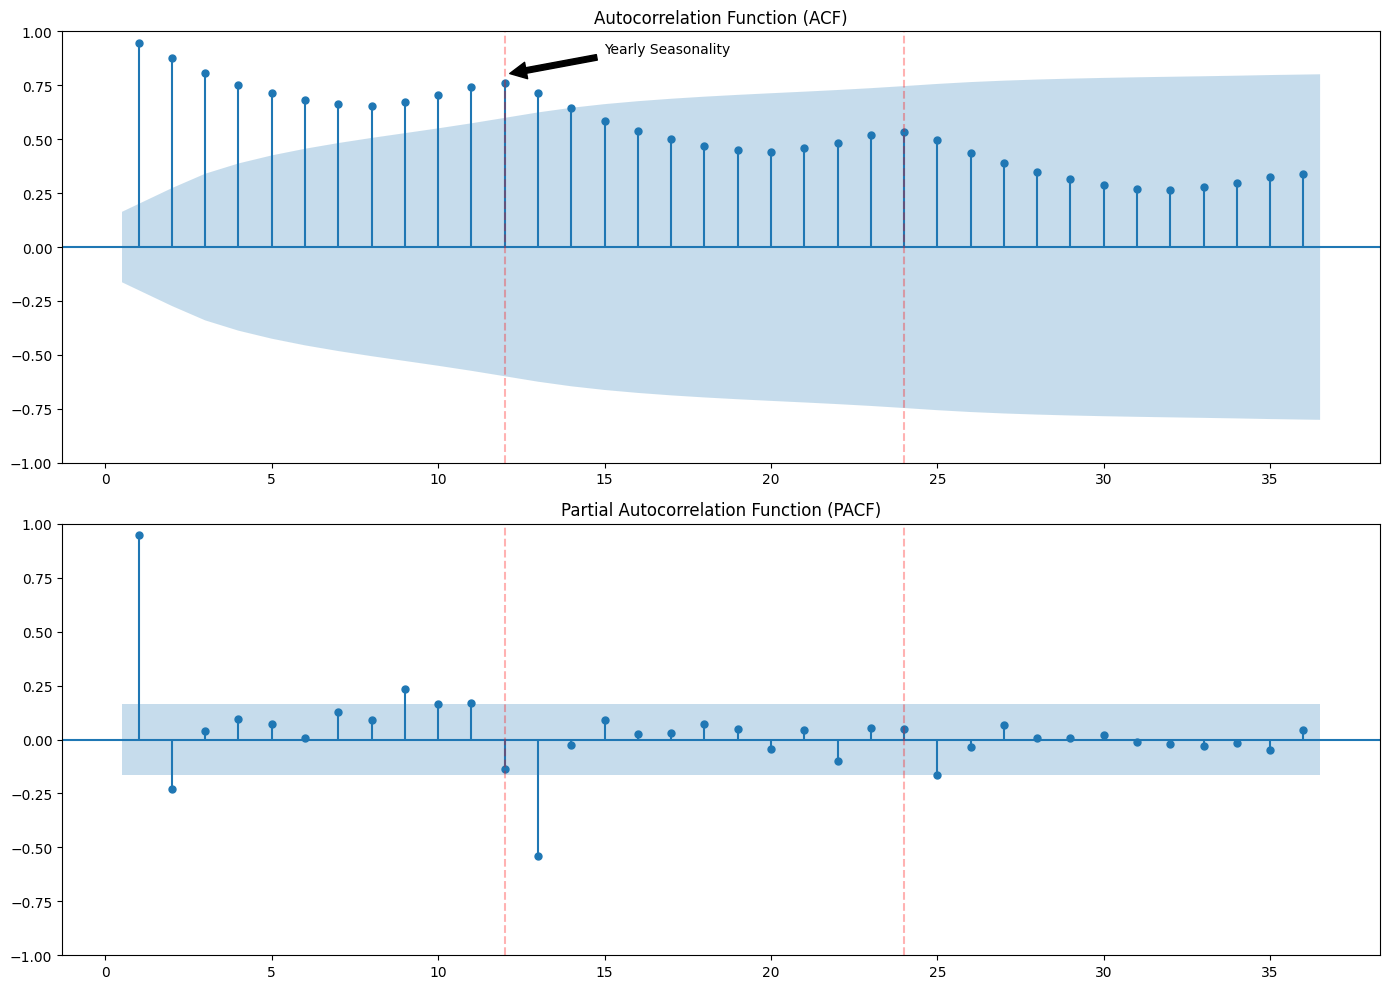

In [110]:
# Enhanced ACF/PACF plots with annotations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# ACF plot with confidence intervals
plot_acf(df['Passengers'], lags=36, ax=ax1, 
         title='Autocorrelation Function (ACF)',
         alpha=0.05,  # 95% confidence level
         zero=False)  # Remove zero lag
ax1.axvline(12, color='red', linestyle='--', alpha=0.3)
ax1.axvline(24, color='red', linestyle='--', alpha=0.3)
ax1.annotate('Yearly Seasonality', 
             xy=(12, 0.8), 
             xytext=(15, 0.9),
             arrowprops=dict(facecolor='black', shrink=0.05))

# PACF plot
plot_pacf(df['Passengers'], lags=36, ax=ax2, 
          title='Partial Autocorrelation Function (PACF)',
          method='ywm',  # Yule-Walker with adjustment
          zero=False)
ax2.axvline(12, color='red', linestyle='--', alpha=0.3)
ax2.axvline(24, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

## **7. Year-over-year Analysis**

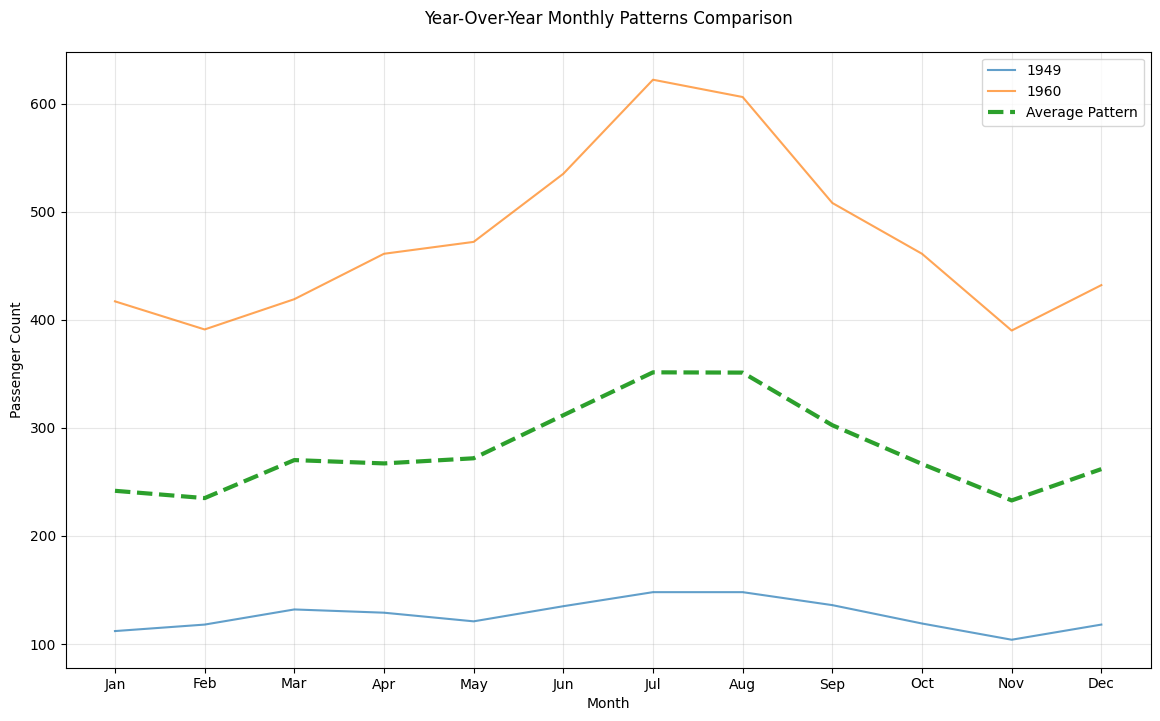

In [111]:
# Create a matrix of year-month values
years = df['Year'].unique()
monthly_data = [df[df['Year'] == year]['Passengers'].values for year in years]

plt.figure(figsize=(14, 8))
plt.plot(monthly_data[0], label=str(years[0]), alpha=0.7)
plt.plot(monthly_data[-1], label=str(years[-1]), alpha=0.7)
plt.plot(np.mean(monthly_data, axis=0), 
         label='Average Pattern', 
         linewidth=3, 
         linestyle='--')

plt.title('Year-Over-Year Monthly Patterns Comparison', pad=20)
plt.xlabel('Month')
plt.ylabel('Passenger Count')
plt.xticks(range(12), list(calendar.month_abbr)[1:13])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **8. Cumulative Analysis**

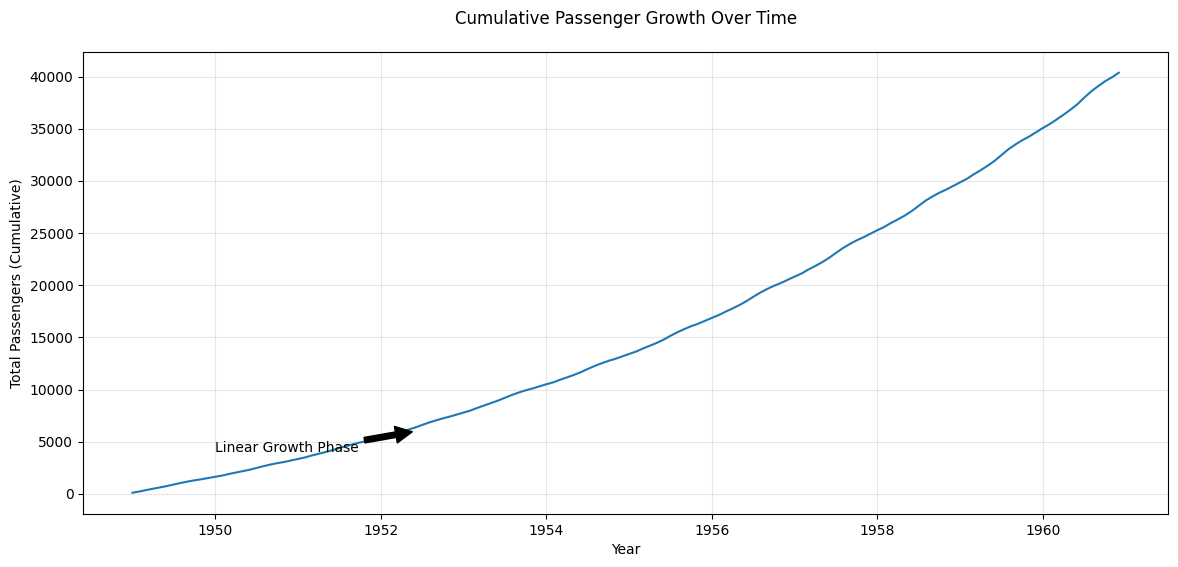

In [112]:
plt.figure(figsize=(14, 6))
plt.plot(df['Passengers'].cumsum(), label='Cumulative Passengers')
plt.title('Cumulative Passenger Growth Over Time', pad=20)
plt.xlabel('Year')
plt.ylabel('Total Passengers (Cumulative)')
plt.grid(True, alpha=0.3)

# Annotate growth periods
plt.annotate('Linear Growth Phase', 
             xy=(pd.to_datetime('1952-06-01'), 6000), 
             xytext=(pd.to_datetime('1950-01-01'), 4000),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

##  **9. Stationarity Tansformation**


Original Data Stationarity:
ADF Statistic: 0.8154
p-value: 0.9919
Critical Values:
   1%: -3.4817
   5%: -2.8840
   10%: -2.5788
Result: Non-stationary (fail to reject null hypothesis)

After Log + Seasonal Differencing:
ADF Statistic: -2.7096
p-value: 0.0724
Critical Values:
   1%: -3.4865
   5%: -2.8862
   10%: -2.5799
Result: Non-stationary (fail to reject null hypothesis)

After Log + Seasonal + First Differencing:
ADF Statistic: -4.4433
p-value: 0.0002
Critical Values:
   1%: -3.4870
   5%: -2.8864
   10%: -2.5800
Result: Stationary (reject null hypothesis)


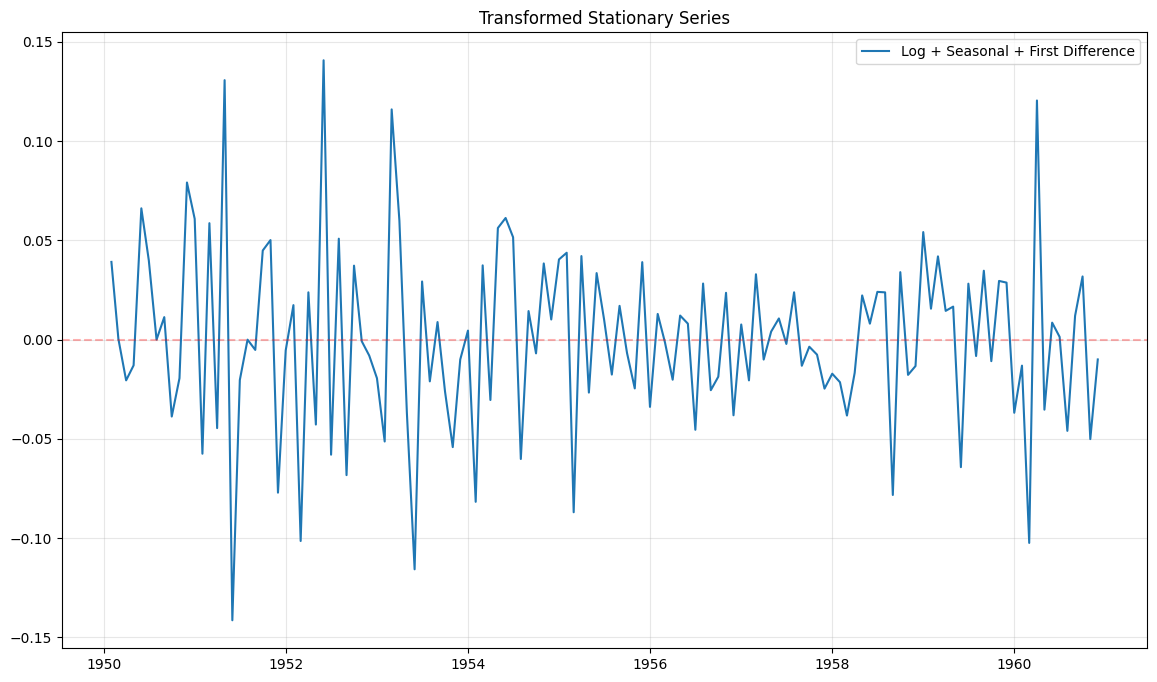

In [113]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    if result[1] < 0.05:
        print("Result: Stationary (reject null hypothesis)")
    else:
        print("Result: Non-stationary (fail to reject null hypothesis)")

# Original data stationarity check
print("\nOriginal Data Stationarity:")
adf_test(df['Passengers'])

# Log transformation
df['log_passengers'] = np.log(df['Passengers'])

# Seasonal differencing (period=12)
df['seasonal_diff'] = df['Passengers'].diff(12)
df['log_seasonal_diff'] = df['log_passengers'].diff(12)

# Combined differencing
df['seasonal_first_diff'] = df['Passengers'].diff().diff(12)
df['log_seasonal_first_diff'] = df['log_passengers'].diff().diff(12)

# Test transformed data
print("\nAfter Log + Seasonal Differencing:")
adf_test(df['log_seasonal_diff'])

print("\nAfter Log + Seasonal + First Differencing:")
adf_test(df['log_seasonal_first_diff'])

# Visualize transformed series
plt.figure(figsize=(14, 8))
plt.plot(df['log_seasonal_first_diff'], label='Log + Seasonal + First Difference')
plt.axhline(0, color='red', linestyle='--', alpha=0.3)
plt.title('Transformed Stationary Series')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **10. Model Selection**

New best: ARIMA(0, 1, 0)(1,0,1,12) AIC=1150.9
New best: ARIMA(0, 1, 1)(1,0,1,12) AIC=1144.8
New best: ARIMA(1, 1, 0)(1,0,1,12) AIC=1144.7
New best: ARIMA(1, 1, 2)(1,0,1,12) AIC=1141.1
New best: ARIMA(2, 1, 1)(1,0,1,12) AIC=1140.4

Final model: ARIMA(2, 1, 1)(1, 0, 1, 12)


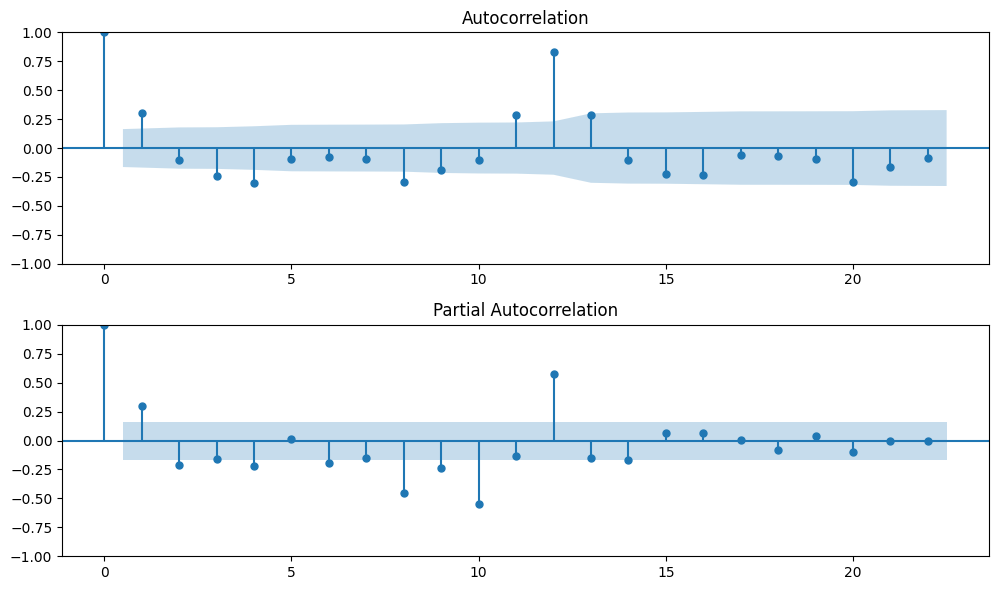

In [114]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import warnings
warnings.filterwarnings("ignore")

def find_best_arima(series, m=12, max_pdq=2):    
    # 1. Determine differencing orders
    def get_d(ts):
        for d in range(2):
            diff = ts.diff(d+1).dropna()
            if len(diff.unique()) > 1:  # Check if series is not constant
                if adfuller(diff)[1] < 0.05:
                    return d
        return 1  # Default
    
    d = get_d(series)
    D = get_d(series.diff().dropna()) if m else 0
    
    # 2. Grid search
    best_aic = float('inf')
    best_pdq = (1, d, 1)  # Reasonable defaults
    best_seasonal = (1, D, 1, m) if m else (0, 0, 0, 0)
    
    for p, q in itertools.product(range(max_pdq+1), repeat=2):
        model = ARIMA(series,
                        order=(p, d, q),
                        seasonal_order=(1, D, 1, m))
        res = model.fit()
        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = (p, d, q)
            print(f"New best: ARIMA{best_pdq}(1,{D},1,{m}) AIC={best_aic:.1f}")
    
    print(f"\nFinal model: ARIMA{best_pdq}{best_seasonal}")
    return best_pdq, best_seasonal

# Usage example:
order, seasonal_order = find_best_arima(df['Passengers'])

# Diagnostic plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6))
plot_acf(df['Passengers'].diff(order[1]).dropna(), ax=ax1)
plot_pacf(df['Passengers'].diff(order[1]).dropna(), ax=ax2, method='ywm')
plt.tight_layout()
plt.show()

## **11. Model Fitting**


Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -456.103
Date:                            Fri, 25 Apr 2025   AIC                            922.205
Time:                                    14:59:07   BIC                            936.016
Sample:                                01-01-1949   HQIC                           927.812
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2298      0.401     -0.573      0.567      -1.016       0.557
ma.L1         -0.09

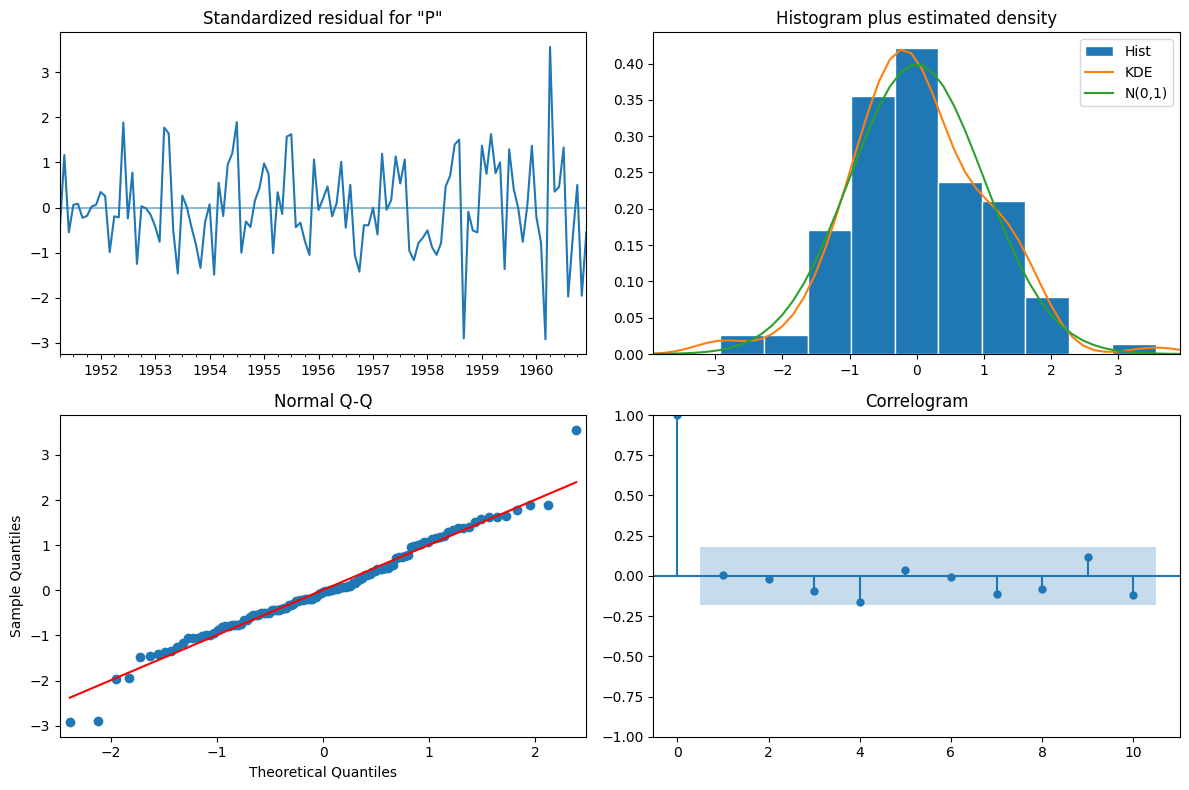

In [115]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
model = SARIMAX(df['Passengers'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print("\nModel Summary:")
print(results.summary())

# Diagnostic plots
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

##### **1. Residuals Plot (Top-Left)**

**What to Check**:  
- Residuals (actual - predicted values) should:  
  ✅ **Fluctuate randomly** around zero (no trends/patterns)  
  ✅ **Have constant variance** (no funnel shapes)  

##### **2. Histogram (Top-Right)**
**What to Check**:  
- Residual distribution should:  
  ✅ **Match a normal bell curve** (N(0,1))  
  ✅ **Be symmetric** (skew ≈ 0)  
  ✅ **Have kurtosis ≈3** (tails not too fat/thin)  

##### **3. Normal Q-Q Plot (Bottom-Left)**
**What to Check**:  
- Points should:  
  ✅ **Follow the red 45° line closely**  
  ✅ **Not deviate systematically at tails** (Slight deviations at extremes are common with financial/volatile data)

##### **4. Correlogram (ACF of Residuals, Bottom-Right)**
**What to Check**:  
- No bars should:  
  ✅ **Cross the blue significance bounds** (95% confidence, All lags insignificant - ideal!  
  ✅ **Show patterns at seasonal lags**

## **12. Forecasting**

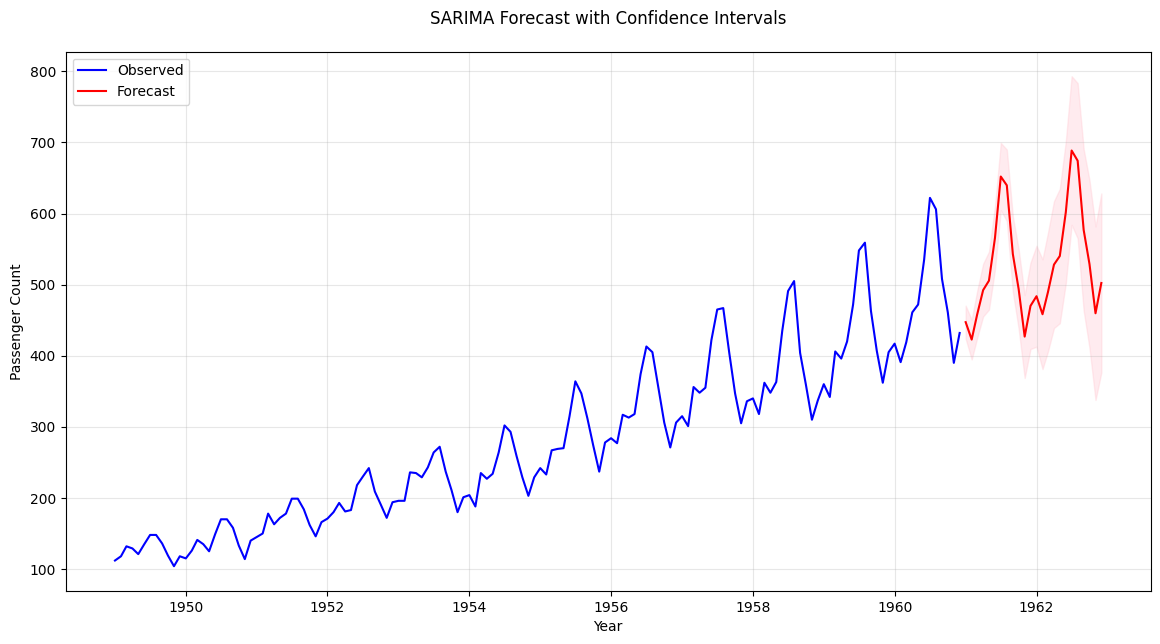

In [116]:
# Forecast next 24 months
forecast_steps = 24
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_int = forecast.conf_int()

# Plot forecast
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Observed', color='blue')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(confidence_int.index,
                confidence_int.iloc[:, 0],
                confidence_int.iloc[:, 1],
                color='pink', alpha=0.3)

plt.title('SARIMA Forecast with Confidence Intervals', pad=20)
plt.xlabel('Year')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **13. Model Evaluation**


Model Performance on Test Set:
MAE: 16.32
MAPE: 3.68%


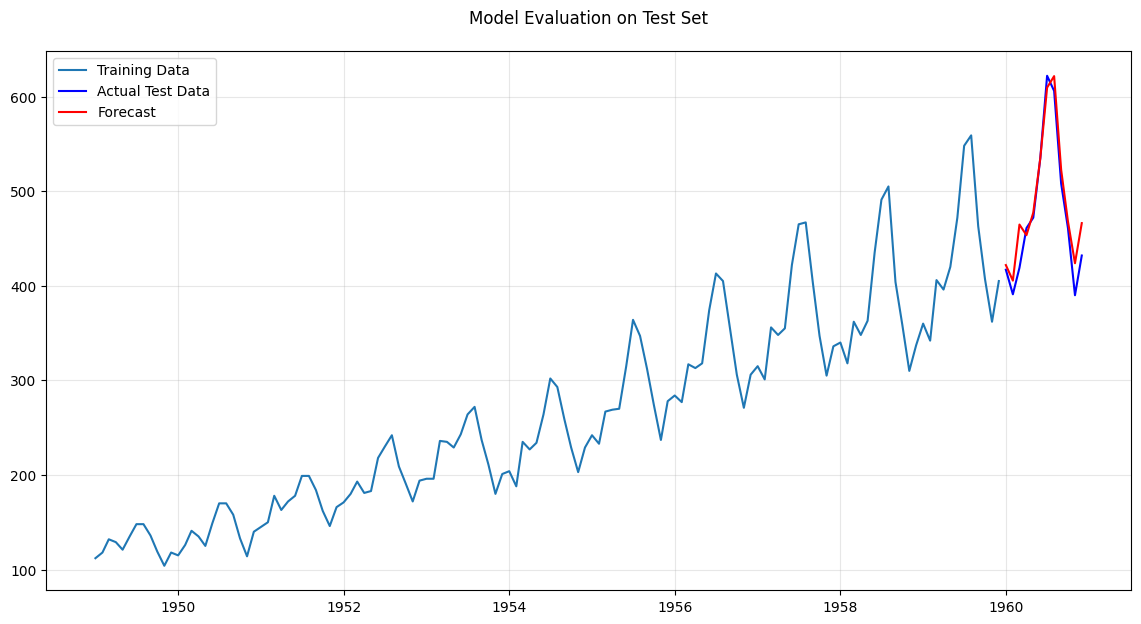

In [117]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Create train-test split (last 12 months for testing)
train = df.iloc[:-12]
test = df.iloc[-12:]

# Fit model on training data
train_model = SARIMAX(train['Passengers'],
                     order=(1, 1, 1),
                     seasonal_order=(1, 1, 1, 12))
train_results = train_model.fit(disp=False)

# Forecast test period
test_forecast = train_results.get_forecast(steps=12)
test_mean = test_forecast.predicted_mean

# Calculate metrics
mae = mean_absolute_error(test['Passengers'], test_mean)
mape = mean_absolute_percentage_error(test['Passengers'], test_mean) * 100

print("\nModel Performance on Test Set:")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot test forecast
plt.figure(figsize=(14, 7))
plt.plot(train['Passengers'], label='Training Data')
plt.plot(test['Passengers'], label='Actual Test Data', color='blue')
plt.plot(test_mean, label='Forecast', color='red')
plt.title('Model Evaluation on Test Set', pad=20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## **14. Final Model Deployment**

In [118]:
# Retrain on complete data for production
final_model = SARIMAX(df['Passengers'],
                     order=(1, 1, 1),
                     seasonal_order=(1, 1, 1, 12))
final_results = final_model.fit(disp=False)

# Save model
import joblib
joblib.dump(final_results, 'sarima_air_passengers.pkl')

print("\nFinal model saved as 'sarima_air_passengers.pkl'")


Final model saved as 'sarima_air_passengers.pkl'
